## Creación del modelo



In [2]:
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Dense, BatchNormalization, Activation
#from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers

import pickle

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, Nadam, SGD, RMSprop
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

import pandas as pd

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
with open("features_Xrays256_BW", "rb") as f:
    Xrays256_BW = pickle.load(f)
    pathology_list = pickle.load(f)
    binary_labels = pickle.load(f)
    multiclass_labels = pickle.load(f)
    cancer_labels = pickle.load(f)
    index_cancer = pickle.load(f)
    index_no_cancer = pickle.load(f)


In [4]:
with open("features_Xrays256_BW_2", "rb") as f:
    features_preentrenada = pickle.load(f)

In [5]:
np.shape(features_preentrenada)

(5606, 512)

In [6]:
np.shape(features_preentrenada)

(5606, 512)

Muestreo así para que en la menor medida un mismo paciente esté en test y en muestra

In [7]:

test_size = int(np.shape(features_preentrenada)[0]*.20)
train_size = np.shape(features_preentrenada)[0]-test_size

In [8]:
test_size + train_size


5606

In [9]:
X_train = features_preentrenada[:train_size]
y_train = cancer_labels[:train_size]

X_test = features_preentrenada[train_size:]
y_test = cancer_labels[train_size:]

In [10]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
#nval = 924
nval = 1000


X_tr = X_train[:-nval]
y_tr = y_train[:-nval]

X_va = X_train[-nval:]
y_va = y_train[-nval:]

#### Remuestreo Train

In [12]:
ind_cancer = np.where(y_tr==1)[0].flatten()
ind_no_cancer = np.where(y_tr!=1)[0].flatten()


In [13]:
np.shape(ind_no_cancer)[0]/ np.shape(ind_cancer)[0]

9.690184049079754

In [14]:
n_resample=8

In [15]:
indice_train = np.concatenate(( np.tile(ind_cancer,(n_resample,1)).flatten(), ind_no_cancer), axis=0, out=None)


In [16]:
np.shape(indice_train)

(5767,)

In [17]:
### desordenamos el índice, para que los registros no estén ordenados en el entrenamiento

np.random.shuffle(indice_train)
indice_train

array([1784, 1031,   36, ..., 2843, 3414, 2960], dtype=int64)

In [18]:
np.shape(X_tr[indice_train])

(5767, 512)

In [19]:
X_tr=X_tr[indice_train]
y_tr=y_tr[indice_train]

#### Remuestreo Validación

In [20]:
ind_cancer_va = np.where(y_va==1)[0].flatten()
ind_no_cancer_va = np.where(y_va!=1)[0].flatten()


In [21]:
np.shape(ind_no_cancer_va)[0]/ np.shape(ind_cancer_va)[0]

7.849557522123894

In [22]:
n_resample_va=8

In [23]:
indice_va = np.concatenate(( np.tile(ind_cancer_va,(n_resample_va,1)).flatten(), ind_no_cancer_va), axis=0, out=None)


In [24]:
np.shape(indice_va)

(1791,)

In [25]:
### desordenamos el índice, para que los registros no estén ordenados en el entrenamiento

np.random.shuffle(indice_va)
indice_train

array([1784, 1031,   36, ..., 2843, 3414, 2960], dtype=int64)

In [26]:
np.shape(X_va[indice_va])

(1791, 512)

In [27]:
X_va=X_va[indice_va]
y_va=y_va[indice_va]

In [28]:
y_va.sum()

904

In [29]:
ind_cancer


array([   5,   10,   11,   18,   27,   45,   47,   59,   67,  100,  101,
        102,  108,  114,  163,  185,  186,  215,  221,  223,  267,  274,
        276,  283,  297,  331,  342,  343,  346,  347,  353,  372,  382,
        391,  400,  431,  437,  445,  467,  519,  525,  589,  638,  639,
        656,  676,  690,  692,  707,  721,  723,  744,  761,  775,  778,
        790,  796,  816,  868,  872,  919,  929,  930,  943,  944,  961,
        982,  985,  996,  997,  998,  999, 1017, 1019, 1036, 1042, 1043,
       1047, 1054, 1077, 1081, 1084, 1088, 1091, 1097, 1129, 1136, 1182,
       1191, 1195, 1201, 1202, 1214, 1219, 1221, 1222, 1239, 1252, 1254,
       1259, 1282, 1302, 1307, 1311, 1312, 1315, 1342, 1363, 1419, 1425,
       1429, 1454, 1480, 1487, 1496, 1504, 1512, 1530, 1539, 1540, 1544,
       1549, 1564, 1573, 1577, 1585, 1597, 1605, 1607, 1617, 1624, 1626,
       1627, 1642, 1644, 1654, 1656, 1657, 1664, 1666, 1683, 1684, 1697,
       1721, 1732, 1733, 1743, 1769, 1779, 1781, 17

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(features_preentrenada, cancer_labels,
#                                                    test_size = .3, shuffle = True)

In [31]:
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(X_test.shape, y_test.shape)

(5767, 512) (5767,)
(1791, 512) (1791,)
(1121, 512) (1121,)


Comprobamos el balanceo

In [32]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_tr),
                                                 y_tr)

#class_weights = {0: 1.,
#                1: 6.}

In [33]:
class_weights #con esto sabemos la proporción

array([0.91278886, 1.1056365 ])

In [34]:
class_weights[1]/class_weights[0]

1.2112730061349692

In [35]:
y_tr

array([0, 0, 0, ..., 1, 1, 1])

In [36]:
np.shape(index_cancer)[0], np.shape(index_no_cancer)[0] 

(553, 5053)

## Baseline: modelo dummy

In [37]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_tr, y_tr)
print("Score de dummy en test:", dummy_model.score(X_test, y_test))

Score de dummy en test: 0.8983050847457628


## Regresión Logística

In [38]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_tr)
X_tr_sc = sc.transform(X_tr)
X_va_sc = sc.transform(X_va)
X_test_sc = sc.transform(X_test)

In [39]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_tr_sc, y_tr)

print("Score de Regresión Logística en test:", LR_model.score(X_test_sc, y_test))

Score de Regresión Logística en test: 0.7430865298840321


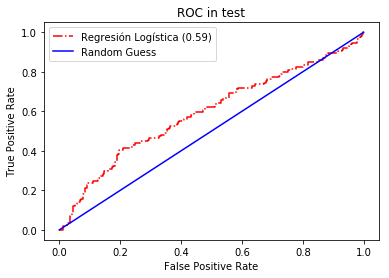

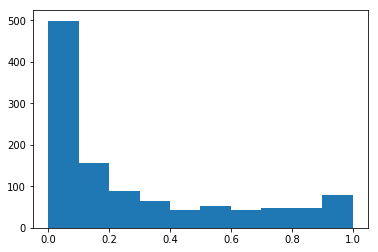

In [40]:
#y_pred_proba = LR_model.predict(X_test_sc)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
y_pred_proba = LR_model.predict_proba(X_test_sc) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Regresión Logística (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

plt.hist(y_pred_proba[:,1])
plt.show()

In [41]:
y_pred_proba = LR_model.predict(X_test)
print(classification_report(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       0.88      0.02      0.04      1007
          1       0.10      0.97      0.18       114

avg / total       0.80      0.12      0.06      1121



## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=101)
RF_model.fit(X_tr, y_tr)
print("Score de Random Forest en test:", RF_model.score(X_test, y_test))

Score de Random Forest en test: 0.8983050847457628


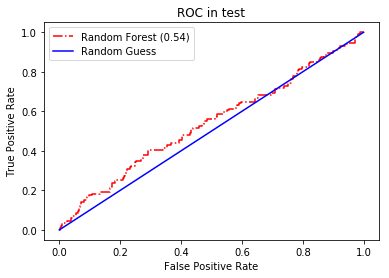

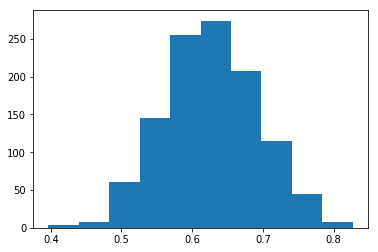

In [43]:
#y_pred_proba = RF_model.predict(X_test)
#fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
y_pred_proba = LR_model.predict_proba(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Random Forest (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

plt.hist(y_pred_proba[:,1])
plt.show()

In [44]:
y_pred_proba = RF_model.predict(X_test)
print(classification_report(y_test, y_pred_proba))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95      1007
          1       0.00      0.00      0.00       114

avg / total       0.81      0.90      0.85      1121



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Red neuronal desacoplada del feature extraction

In [45]:
def create_model():
    #adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #nadam = Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.7, nesterov=True)
    adam = Adam(lr=0.0001)
    #rmsprop = RMSprop(lr=0.0001)
    
    l1 =0.01
    l2 =0.01
    
    modelo_desacoplado = Sequential()
    modelo_desacoplado.add(Dropout(0.6, input_shape=(X_tr.shape[1],)))
    modelo_desacoplado.add(BatchNormalization())
    modelo_desacoplado.add(Dense(30,  kernel_initializer='he_uniform',
                                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                                ))
    modelo_desacoplado.add(Dropout(0.6))
    modelo_desacoplado.add(BatchNormalization())
    modelo_desacoplado.add(Activation('relu'))
    modelo_desacoplado.add(Dense(20, kernel_initializer='he_uniform',
                                 kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                                ))
    modelo_desacoplado.add(Dropout(0.5))
    modelo_desacoplado.add(BatchNormalization())
    modelo_desacoplado.add(Activation('relu'))
    modelo_desacoplado.add(Dense(1, activation='sigmoid'))

    modelo_desacoplado.compile(optimizer= adam,
                               loss='binary_crossentropy',
                               metrics=["accuracy"])
    return modelo_desacoplado

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                15390     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
__________

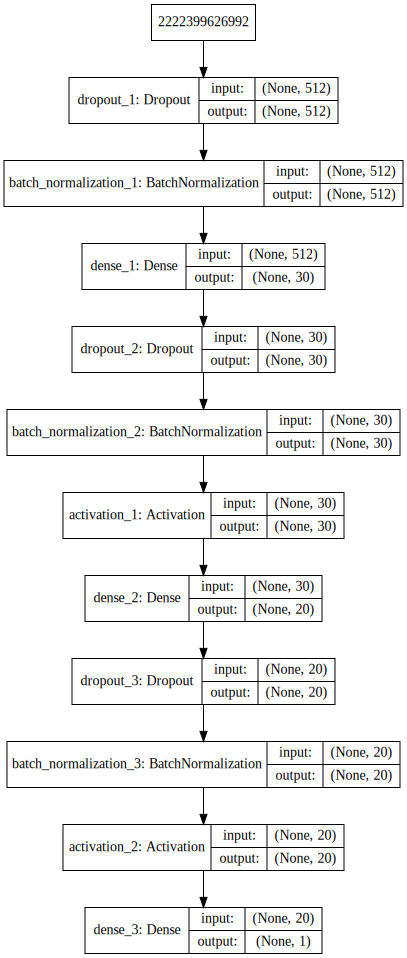

In [46]:
modelo_desacoplado=create_model()

print(modelo_desacoplado.summary())
SVG(model_to_dot(modelo_desacoplado,show_shapes=True).create(prog='dot', format='svg'))

In [47]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_acc))
    plt.title('performance del modelo del modelo', fontsize=18)
    plt.ylabel('performance', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.legend(['entrenamiento', 'validacion'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [48]:

modelo_desacoplado=create_model() # lo pongo aqui de nuevo para que no se nos olvide inicializar los pesos del modelo

acum_tr = []
acum_val = []
best_model = []
val_loss = [] 
loss = []
val_acc= []
acc = []

Epoca:  1
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 1s 200us/step - loss: 10.9933 - acc: 0.5311 - val_loss: 10.7682 - val_acc: 0.5014

Epoch 00001: val_loss improved from inf to 10.76815, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  2
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 10.2799 - acc: 0.5289 - val_loss: 10.0864 - val_acc: 0.4835

Epoch 00001: val_loss improved from 10.76815 to 10.08637, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  3
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 9.6171 - acc: 0.5237 - val_loss: 9.2456 - val_acc: 0.4830

Epoch 00001: val_loss improved from 10.08637 to 9.24561, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  4
Train on 5767 sa

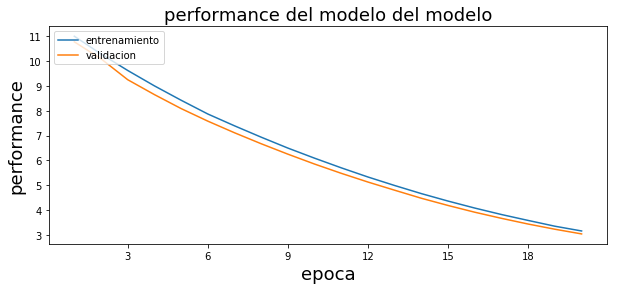

Epoca:  21
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 50us/step - loss: 2.9830 - acc: 0.5273 - val_loss: 2.8692 - val_acc: 0.5299

Epoch 00001: val_loss improved from 3.04496 to 2.86924, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  22
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 2.8148 - acc: 0.5284 - val_loss: 2.7115 - val_acc: 0.5321

Epoch 00001: val_loss improved from 2.86924 to 2.71151, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  23
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 2.6648 - acc: 0.5280 - val_loss: 2.5691 - val_acc: 0.5394

Epoch 00001: val_loss improved from 2.71151 to 2.56911, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  24
Train on 5767 sam

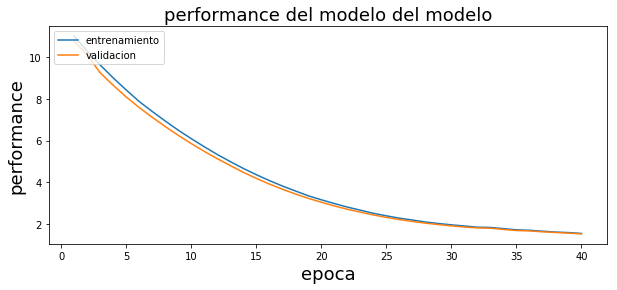

Epoca:  41
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 1.5201 - acc: 0.5686 - val_loss: 1.4995 - val_acc: 0.5784

Epoch 00001: val_loss improved from 1.52896 to 1.49946, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  42
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 1.4976 - acc: 0.5720 - val_loss: 1.4833 - val_acc: 0.5757

Epoch 00001: val_loss improved from 1.49946 to 1.48327, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  43
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 1.4760 - acc: 0.5663 - val_loss: 1.4562 - val_acc: 0.5868

Epoch 00001: val_loss improved from 1.48327 to 1.45617, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  44
Train on 5767 sam

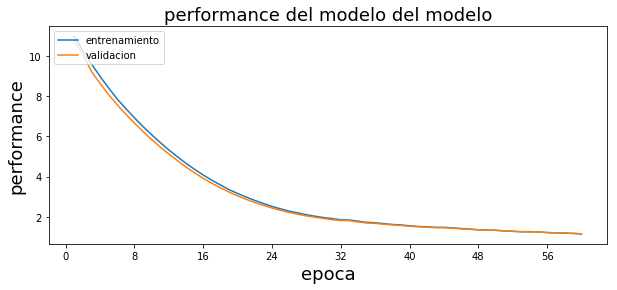

Epoca:  61
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 58us/step - loss: 1.1282 - acc: 0.5939 - val_loss: 1.1362 - val_acc: 0.6013

Epoch 00001: val_loss improved from 1.15386 to 1.13619, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  62
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 57us/step - loss: 1.1395 - acc: 0.5830 - val_loss: 1.1429 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 1.13619

Epoch 00001: saving model to last_model.h5
Epoca:  63
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 81us/step - loss: 1.1313 - acc: 0.5911 - val_loss: 1.1358 - val_acc: 0.6203

Epoch 00001: val_loss improved from 1.13619 to 1.13576, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  64
Train on 5767 samples, validate on 1791 samples
Epoc

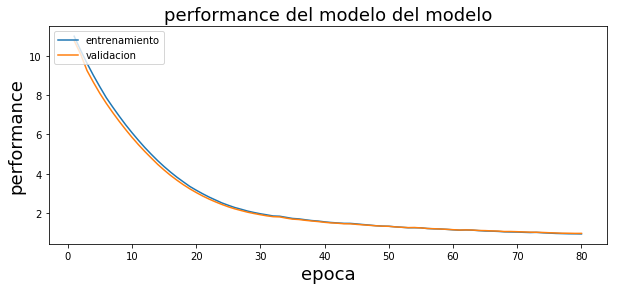

Epoca:  81
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.9573 - acc: 0.5923 - val_loss: 0.9792 - val_acc: 0.5874

Epoch 00001: val_loss did not improve from 0.96547

Epoch 00001: saving model to last_model.h5
Epoca:  82
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.9529 - acc: 0.5994 - val_loss: 0.9700 - val_acc: 0.6164

Epoch 00001: val_loss did not improve from 0.96547

Epoch 00001: saving model to last_model.h5
Epoca:  83
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.9287 - acc: 0.6100 - val_loss: 0.9517 - val_acc: 0.5902

Epoch 00001: val_loss improved from 0.96547 to 0.95169, saving model to best_model.h5

Epoch 00001: saving model to last_model.h5
Epoca:  84
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==================

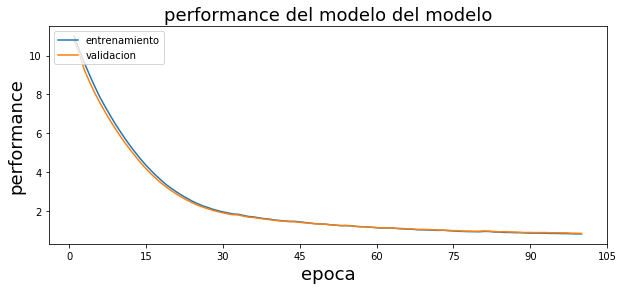

Epoca:  101
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.8277 - acc: 0.6138 - val_loss: 0.8575 - val_acc: 0.5879

Epoch 00001: val_loss did not improve from 0.85118

Epoch 00001: saving model to last_model.h5
Epoca:  102
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 51us/step - loss: 0.8163 - acc: 0.6248 - val_loss: 0.8549 - val_acc: 0.5773

Epoch 00001: val_loss did not improve from 0.85118

Epoch 00001: saving model to last_model.h5
Epoca:  103
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.8176 - acc: 0.6222 - val_loss: 0.8556 - val_acc: 0.5706

Epoch 00001: val_loss did not improve from 0.85118

Epoch 00001: saving model to last_model.h5
Epoca:  104
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 48us/step - 

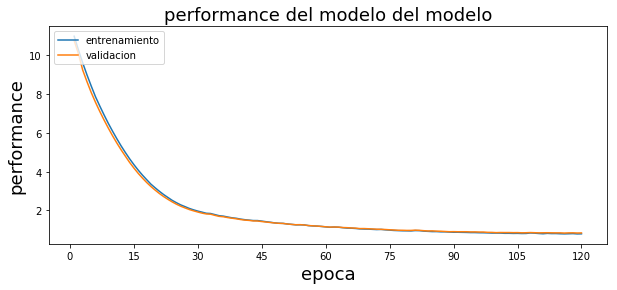

Epoca:  121
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 52us/step - loss: 0.7913 - acc: 0.6230 - val_loss: 0.8351 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 0.82936

Epoch 00001: saving model to last_model.h5
Epoca:  122
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7869 - acc: 0.6232 - val_loss: 0.8312 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.82936

Epoch 00001: saving model to last_model.h5
Epoca:  123
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7925 - acc: 0.6203 - val_loss: 0.8344 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.82936

Epoch 00001: saving model to last_model.h5
Epoca:  124
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - 

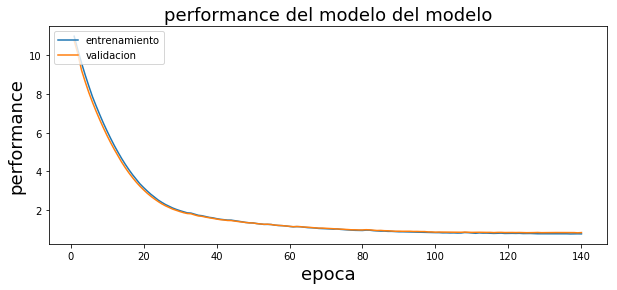

Epoca:  141
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7640 - acc: 0.6353 - val_loss: 0.8354 - val_acc: 0.5729

Epoch 00001: val_loss did not improve from 0.81769

Epoch 00001: saving model to last_model.h5
Epoca:  142
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7585 - acc: 0.6343 - val_loss: 0.8291 - val_acc: 0.6002

Epoch 00001: val_loss did not improve from 0.81769

Epoch 00001: saving model to last_model.h5
Epoca:  143
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7608 - acc: 0.6303 - val_loss: 0.8254 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.81769

Epoch 00001: saving model to last_model.h5
Epoca:  144
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - 

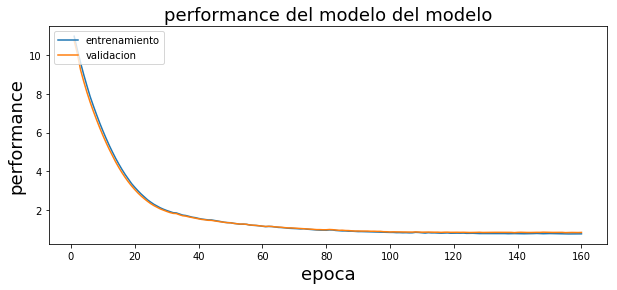

Epoca:  161
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7542 - acc: 0.6509 - val_loss: 0.8308 - val_acc: 0.5662

Epoch 00001: val_loss did not improve from 0.81744

Epoch 00001: saving model to last_model.h5
Epoca:  162
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7536 - acc: 0.6416 - val_loss: 0.8253 - val_acc: 0.5773

Epoch 00001: val_loss did not improve from 0.81744

Epoch 00001: saving model to last_model.h5
Epoca:  163
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7586 - acc: 0.6367 - val_loss: 0.8299 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.81744

Epoch 00001: saving model to last_model.h5
Epoca:  164
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - 

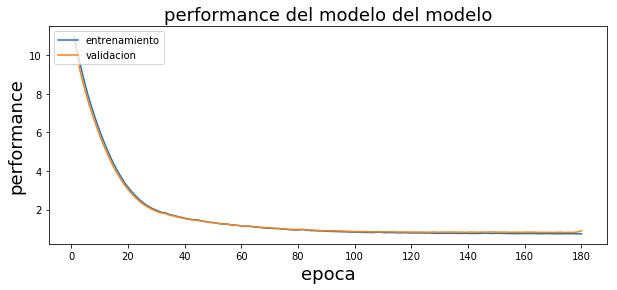

Epoca:  181
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7441 - acc: 0.6471 - val_loss: 0.9522 - val_acc: 0.5801

Epoch 00001: val_loss did not improve from 0.80899

Epoch 00001: saving model to last_model.h5
Epoca:  182
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7399 - acc: 0.6470 - val_loss: 0.9624 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.80899

Epoch 00001: saving model to last_model.h5
Epoca:  183
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7446 - acc: 0.6395 - val_loss: 1.0062 - val_acc: 0.5779

Epoch 00001: val_loss did not improve from 0.80899

Epoch 00001: saving model to last_model.h5
Epoca:  184
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - 

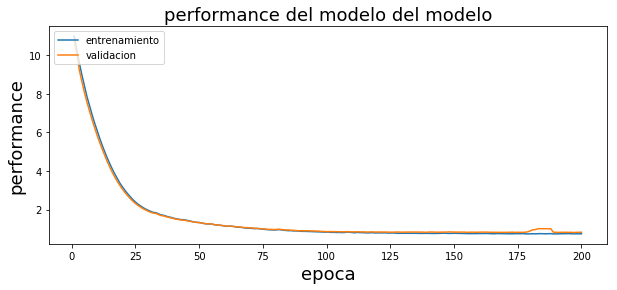

Epoca:  201
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7390 - acc: 0.6447 - val_loss: 0.8197 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  202
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7390 - acc: 0.6516 - val_loss: 0.8167 - val_acc: 0.6041

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  203
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7298 - acc: 0.6586 - val_loss: 0.8105 - val_acc: 0.6052

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  204
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 52us/step - 

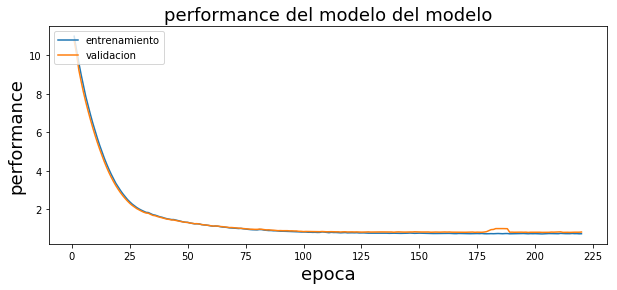

Epoca:  221
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7483 - acc: 0.6515 - val_loss: 0.8279 - val_acc: 0.6030

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  222
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7494 - acc: 0.6433 - val_loss: 0.8360 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  223
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - ETA: 0s - loss: 0.7521 - acc: 0.650 - 0s 42us/step - loss: 0.7522 - acc: 0.6489 - val_loss: 0.8460 - val_acc: 0.5628

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  224
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [===========

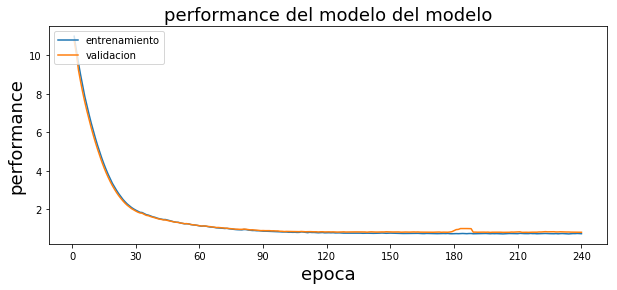

Epoca:  241
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 53us/step - loss: 0.7435 - acc: 0.6468 - val_loss: 0.8125 - val_acc: 0.5623

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  242
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 73us/step - loss: 0.7440 - acc: 0.6504 - val_loss: 0.8219 - val_acc: 0.5494

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  243
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 68us/step - loss: 0.7414 - acc: 0.6565 - val_loss: 0.8197 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  244
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - 

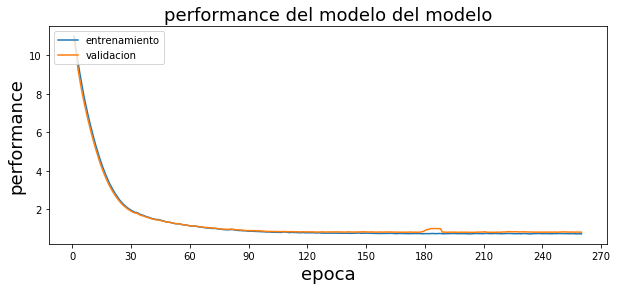

Epoca:  261
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7221 - acc: 0.6561 - val_loss: 0.8262 - val_acc: 0.5773

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  262
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7424 - acc: 0.6508 - val_loss: 0.8266 - val_acc: 0.5717

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  263
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7527 - acc: 0.6544 - val_loss: 0.8342 - val_acc: 0.5729

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  264
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - 

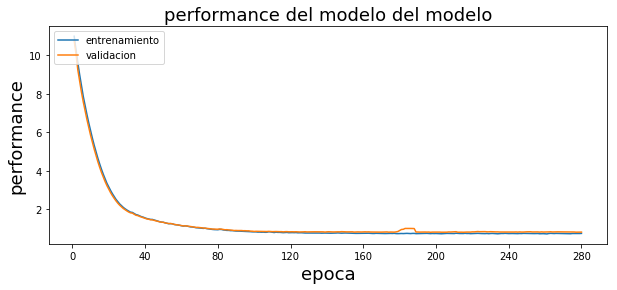

Epoca:  281
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7462 - acc: 0.6574 - val_loss: 0.8209 - val_acc: 0.5734

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  282
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7398 - acc: 0.6594 - val_loss: 0.8320 - val_acc: 0.5706

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  283
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7367 - acc: 0.6601 - val_loss: 0.8337 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  284
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - 

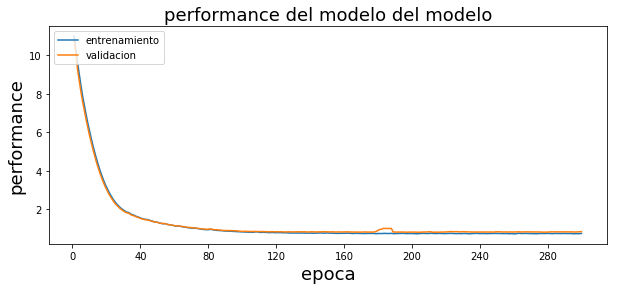

Epoca:  301
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7454 - acc: 0.6485 - val_loss: 0.8330 - val_acc: 0.5678

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  302
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7361 - acc: 0.6645 - val_loss: 0.8251 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  303
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7433 - acc: 0.6442 - val_loss: 0.8272 - val_acc: 0.5662

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  304
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

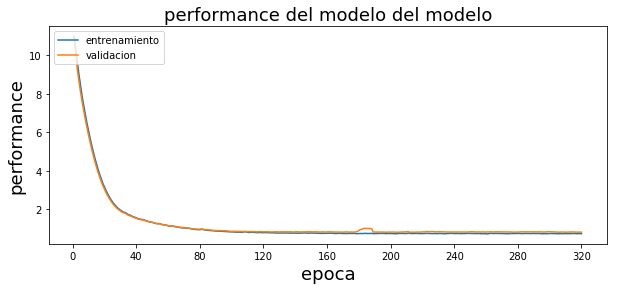

Epoca:  321
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7523 - acc: 0.6424 - val_loss: 0.8164 - val_acc: 0.6075

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  322
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7410 - acc: 0.6641 - val_loss: 0.8127 - val_acc: 0.5768

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  323
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7349 - acc: 0.6617 - val_loss: 0.8200 - val_acc: 0.5824

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  324
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - 

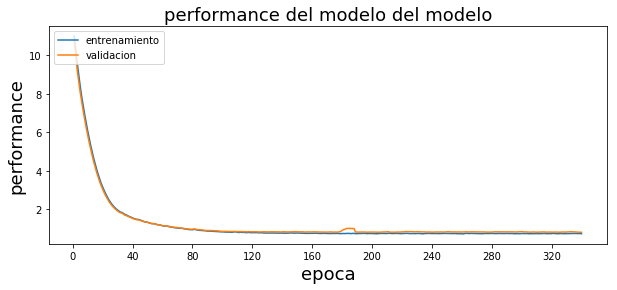

Epoca:  341
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7358 - acc: 0.6640 - val_loss: 0.8123 - val_acc: 0.5740

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  342
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7293 - acc: 0.6624 - val_loss: 0.8126 - val_acc: 0.5768

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  343
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7384 - acc: 0.6470 - val_loss: 0.8081 - val_acc: 0.6013

Epoch 00001: val_loss did not improve from 0.80712

Epoch 00001: saving model to last_model.h5
Epoca:  344
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - 

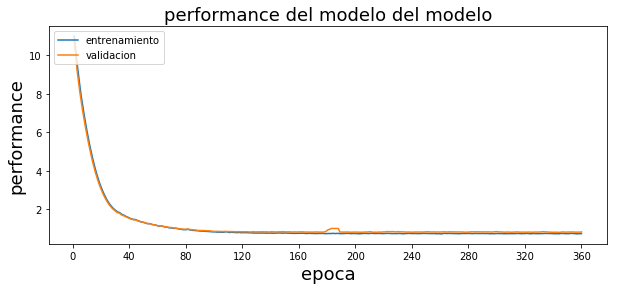

Epoca:  361
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 37us/step - loss: 0.7427 - acc: 0.6534 - val_loss: 0.8274 - val_acc: 0.5958

Epoch 00001: val_loss did not improve from 0.80237

Epoch 00001: saving model to last_model.h5
Epoca:  362
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7433 - acc: 0.6593 - val_loss: 0.8271 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.80237

Epoch 00001: saving model to last_model.h5
Epoca:  363
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7390 - acc: 0.6650 - val_loss: 0.8327 - val_acc: 0.5924

Epoch 00001: val_loss did not improve from 0.80237

Epoch 00001: saving model to last_model.h5
Epoca:  364
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - 

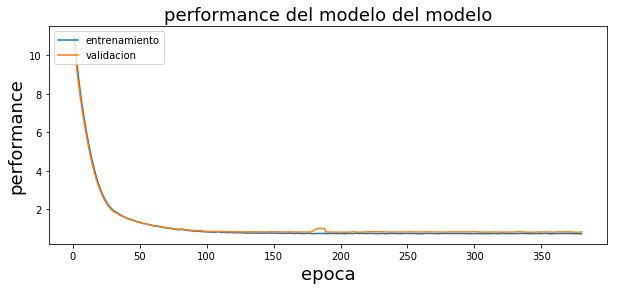

Epoca:  381
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7386 - acc: 0.6567 - val_loss: 0.8181 - val_acc: 0.5818

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  382
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7335 - acc: 0.6672 - val_loss: 0.8259 - val_acc: 0.5768

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  383
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7311 - acc: 0.6674 - val_loss: 0.8189 - val_acc: 0.5757

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  384
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - 

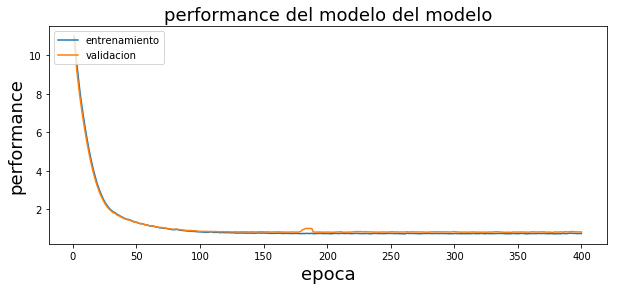

Epoca:  401
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7540 - acc: 0.6539 - val_loss: 0.8258 - val_acc: 0.5745

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  402
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7388 - acc: 0.6664 - val_loss: 0.8322 - val_acc: 0.5874

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  403
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7388 - acc: 0.6608 - val_loss: 0.8305 - val_acc: 0.5807

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  404
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - 

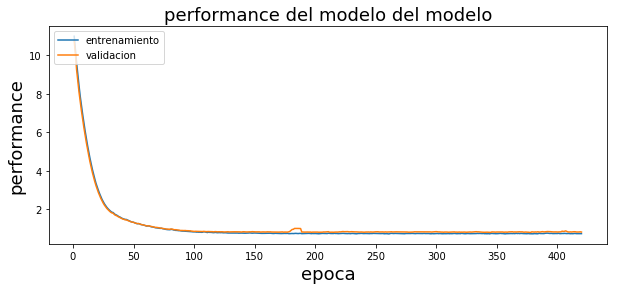

Epoca:  421
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7410 - acc: 0.6587 - val_loss: 0.8204 - val_acc: 0.6030

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  422
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7367 - acc: 0.6577 - val_loss: 0.8250 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  423
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7333 - acc: 0.6608 - val_loss: 0.8264 - val_acc: 0.5969

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  424
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - 

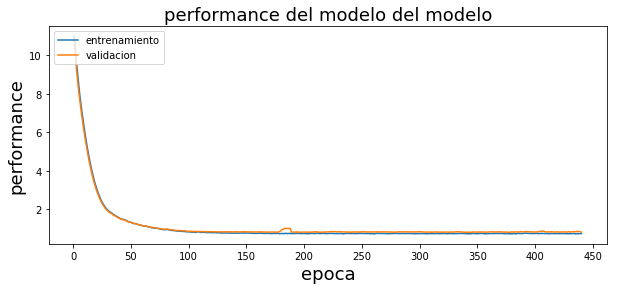

Epoca:  441
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7351 - acc: 0.6652 - val_loss: 0.8227 - val_acc: 0.5896

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  442
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7328 - acc: 0.6740 - val_loss: 0.8343 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  443
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7501 - acc: 0.6643 - val_loss: 0.8266 - val_acc: 0.5801

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  444
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - 

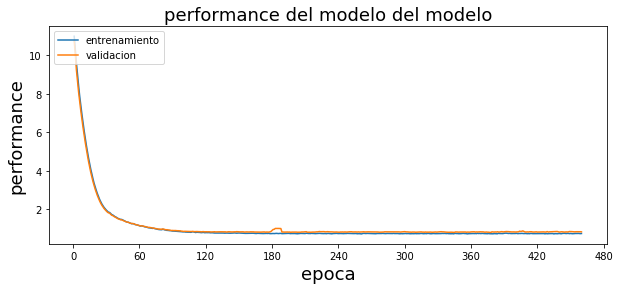

Epoca:  461
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 37us/step - loss: 0.7387 - acc: 0.6631 - val_loss: 0.8333 - val_acc: 0.5997

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  462
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 37us/step - loss: 0.7333 - acc: 0.6700 - val_loss: 0.8375 - val_acc: 0.5639

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  463
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7324 - acc: 0.6681 - val_loss: 0.8353 - val_acc: 0.5812

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  464
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - 

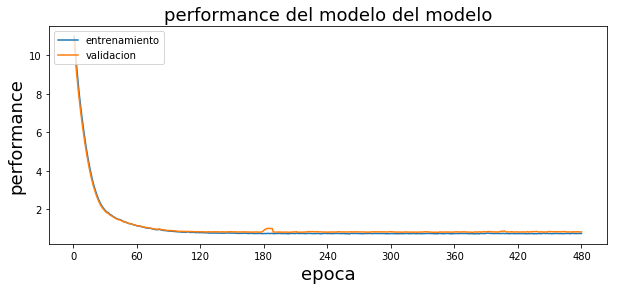

Epoca:  481
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 37us/step - loss: 0.7392 - acc: 0.6697 - val_loss: 0.8357 - val_acc: 0.5863

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  482
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 37us/step - loss: 0.7381 - acc: 0.6674 - val_loss: 0.8235 - val_acc: 0.5757

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  483
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7430 - acc: 0.6522 - val_loss: 0.8299 - val_acc: 0.5812

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  484
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - 

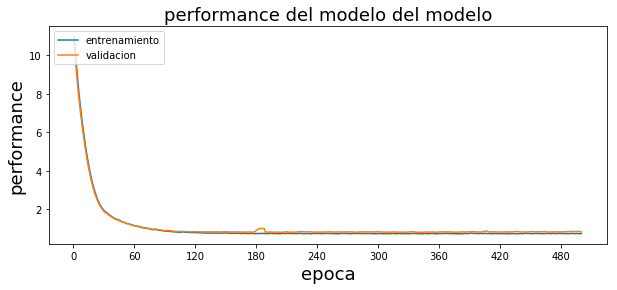

Epoca:  501
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7422 - acc: 0.6617 - val_loss: 0.8200 - val_acc: 0.5913

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  502
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7390 - acc: 0.6662 - val_loss: 0.8235 - val_acc: 0.5885

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  503
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7480 - acc: 0.6561 - val_loss: 0.8201 - val_acc: 0.5846

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  504
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

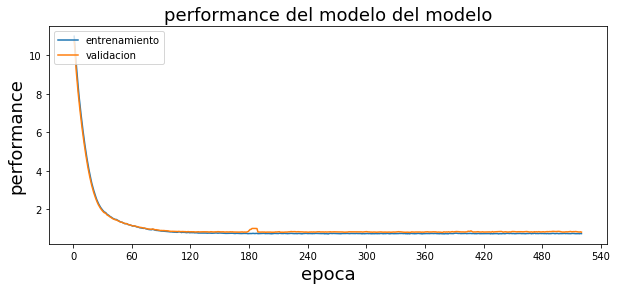

Epoca:  521
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 51us/step - loss: 0.7406 - acc: 0.6646 - val_loss: 0.8206 - val_acc: 0.5969

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  522
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 49us/step - loss: 0.7382 - acc: 0.6607 - val_loss: 0.8217 - val_acc: 0.5980

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  523
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7422 - acc: 0.6579 - val_loss: 0.8368 - val_acc: 0.5824

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  524
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - 

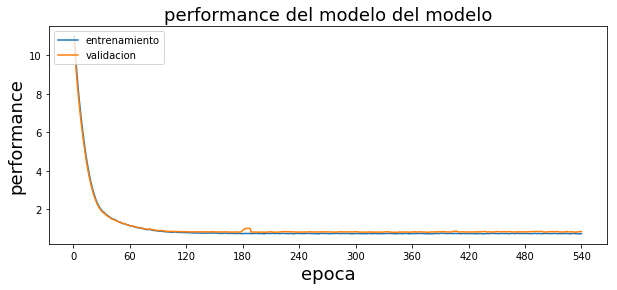

Epoca:  541
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7543 - acc: 0.6624 - val_loss: 0.8519 - val_acc: 0.6002

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  542
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 50us/step - loss: 0.7536 - acc: 0.6601 - val_loss: 0.8547 - val_acc: 0.5779

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  543
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7465 - acc: 0.6698 - val_loss: 0.8550 - val_acc: 0.5868

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  544
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - 

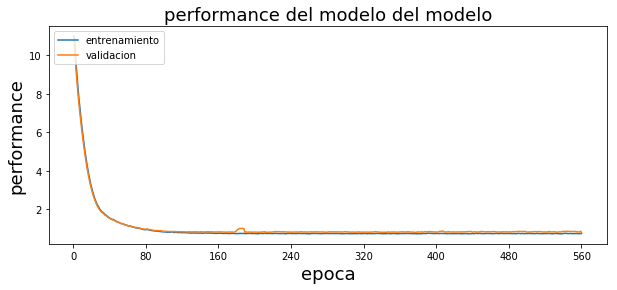

Epoca:  561
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7325 - acc: 0.6754 - val_loss: 0.8290 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  562
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7374 - acc: 0.6697 - val_loss: 0.8326 - val_acc: 0.5695

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  563
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7419 - acc: 0.6653 - val_loss: 0.8265 - val_acc: 0.5918

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  564
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 52us/step - 

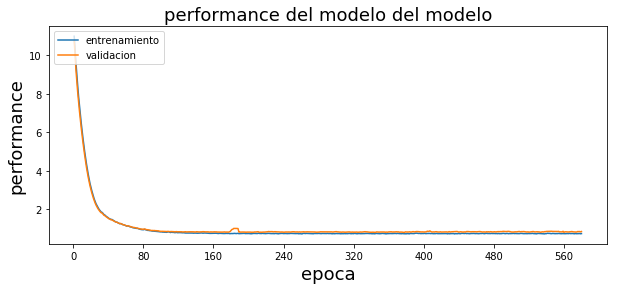

Epoca:  581
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7420 - acc: 0.6615 - val_loss: 0.8415 - val_acc: 0.5857

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  582
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7374 - acc: 0.6714 - val_loss: 0.8462 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  583
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7406 - acc: 0.6634 - val_loss: 0.8479 - val_acc: 0.6170

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  584
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

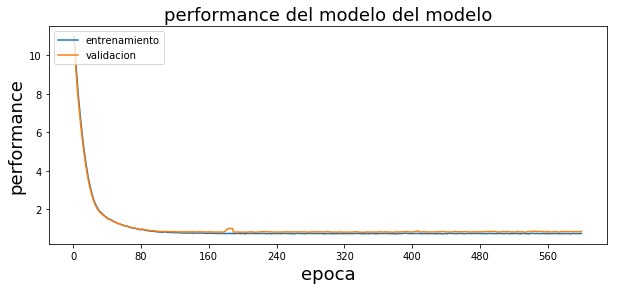

Epoca:  601
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7424 - acc: 0.6631 - val_loss: 0.8506 - val_acc: 0.6008

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  602
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7301 - acc: 0.6785 - val_loss: 0.8447 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  603
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7557 - acc: 0.6478 - val_loss: 0.8392 - val_acc: 0.5684

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  604
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - 

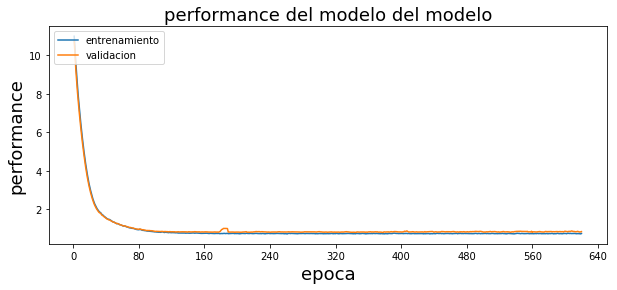

Epoca:  621
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7368 - acc: 0.6693 - val_loss: 0.8522 - val_acc: 0.5935

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  622
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7475 - acc: 0.6693 - val_loss: 0.8484 - val_acc: 0.5840

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  623
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7478 - acc: 0.6683 - val_loss: 0.8353 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  624
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

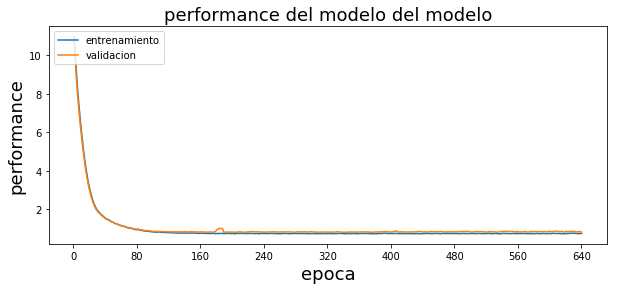

Epoca:  641
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7476 - acc: 0.6641 - val_loss: 0.8418 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  642
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7500 - acc: 0.6553 - val_loss: 0.8442 - val_acc: 0.5868

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  643
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7362 - acc: 0.6712 - val_loss: 0.8495 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  644
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

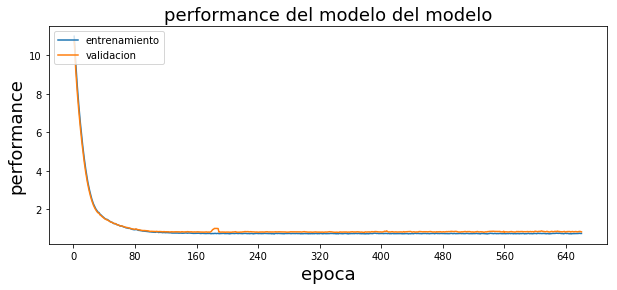

Epoca:  661
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7323 - acc: 0.6745 - val_loss: 0.8441 - val_acc: 0.6013

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  662
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7333 - acc: 0.6749 - val_loss: 0.8343 - val_acc: 0.5952

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  663
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7354 - acc: 0.6754 - val_loss: 0.8190 - val_acc: 0.6058

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  664
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - 

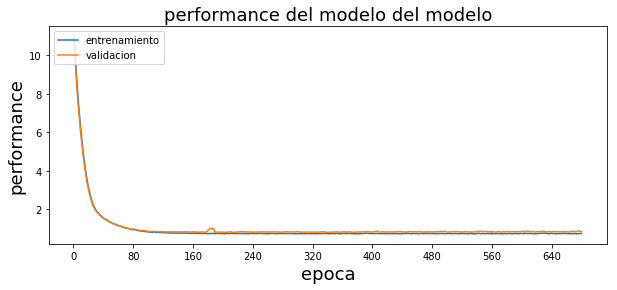

Epoca:  681
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7403 - acc: 0.6607 - val_loss: 0.8501 - val_acc: 0.5812

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  682
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7383 - acc: 0.6695 - val_loss: 0.8471 - val_acc: 0.6080

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  683
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7395 - acc: 0.6676 - val_loss: 0.8500 - val_acc: 0.5952

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  684
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - 

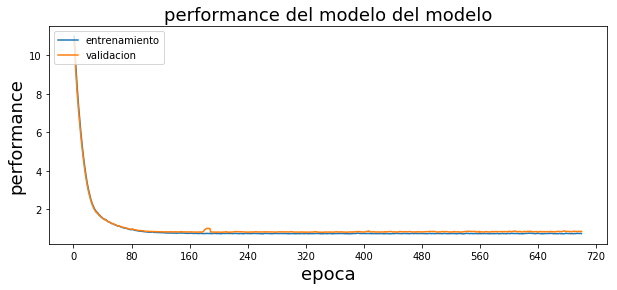

Epoca:  701
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7440 - acc: 0.6612 - val_loss: 0.8513 - val_acc: 0.5824

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  702
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7440 - acc: 0.6627 - val_loss: 0.8463 - val_acc: 0.5768

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  703
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7421 - acc: 0.6735 - val_loss: 0.8578 - val_acc: 0.5818

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  704
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - 

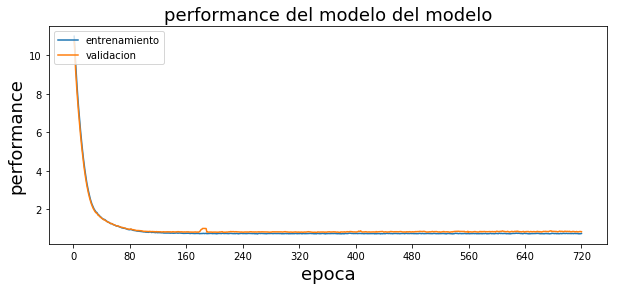

Epoca:  721
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7537 - acc: 0.6515 - val_loss: 0.8300 - val_acc: 0.6114

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  722
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 48us/step - loss: 0.7297 - acc: 0.6757 - val_loss: 0.8378 - val_acc: 0.5946

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  723
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7375 - acc: 0.6633 - val_loss: 0.8437 - val_acc: 0.5578

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  724
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - 

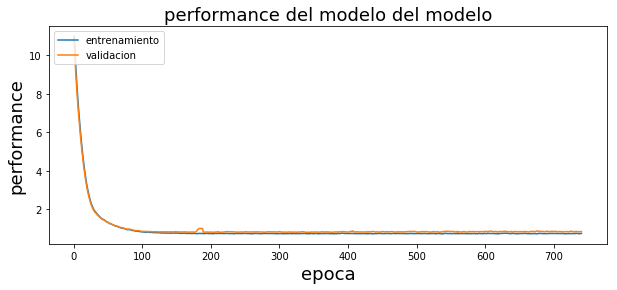

Epoca:  741
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7368 - acc: 0.6671 - val_loss: 0.8593 - val_acc: 0.5784

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  742
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7377 - acc: 0.6719 - val_loss: 0.8426 - val_acc: 0.5907

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  743
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7449 - acc: 0.6582 - val_loss: 0.8395 - val_acc: 0.5991

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  744
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

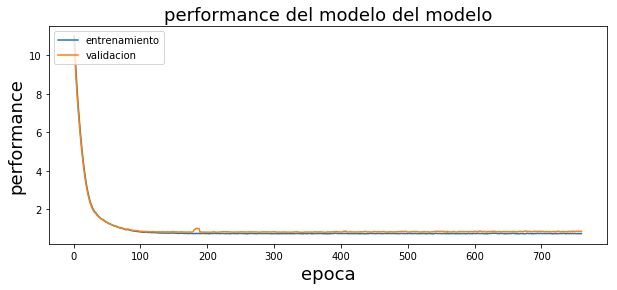

Epoca:  761
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7416 - acc: 0.6652 - val_loss: 0.8638 - val_acc: 0.5673

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  762
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7491 - acc: 0.6634 - val_loss: 0.8546 - val_acc: 0.5634

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  763
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7377 - acc: 0.6712 - val_loss: 0.8603 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  764
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

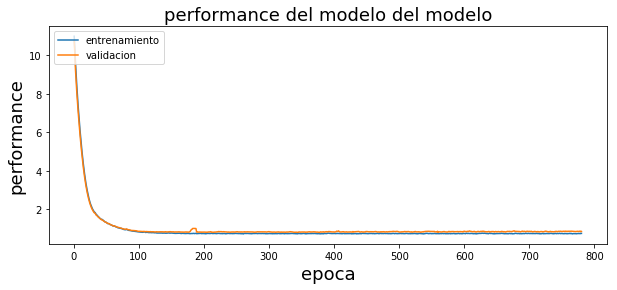

Epoca:  781
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7464 - acc: 0.6607 - val_loss: 0.8456 - val_acc: 0.6052

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  782
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7496 - acc: 0.6586 - val_loss: 0.8329 - val_acc: 0.6220

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  783
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7449 - acc: 0.6608 - val_loss: 0.8464 - val_acc: 0.6025

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  784
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

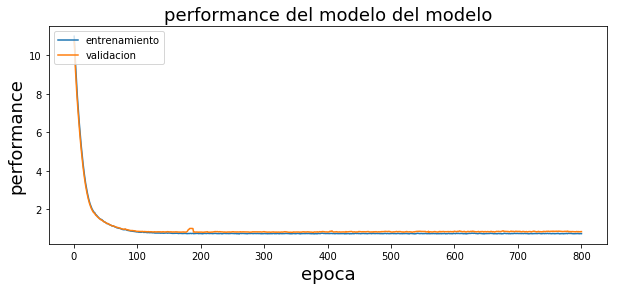

Epoca:  801
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7348 - acc: 0.6652 - val_loss: 0.8406 - val_acc: 0.5796

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  802
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7425 - acc: 0.6591 - val_loss: 0.8582 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  803
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7387 - acc: 0.6688 - val_loss: 0.8503 - val_acc: 0.5935

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  804
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

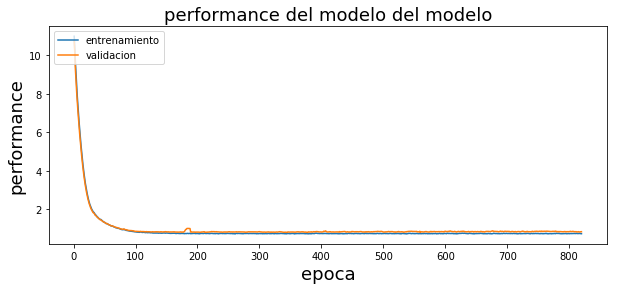

Epoca:  821
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7365 - acc: 0.6655 - val_loss: 0.8357 - val_acc: 0.5991

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  822
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7339 - acc: 0.6737 - val_loss: 0.8514 - val_acc: 0.5835

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  823
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7331 - acc: 0.6731 - val_loss: 0.8527 - val_acc: 0.5874

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  824
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - ETA: 0s - loss:

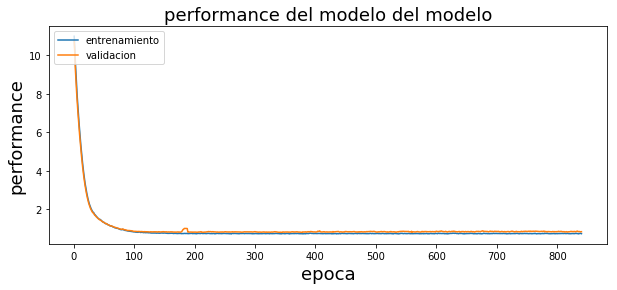

Epoca:  841
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7496 - acc: 0.6679 - val_loss: 0.8403 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  842
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7493 - acc: 0.6560 - val_loss: 0.8236 - val_acc: 0.6036

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  843
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7393 - acc: 0.6688 - val_loss: 0.8319 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  844
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - 

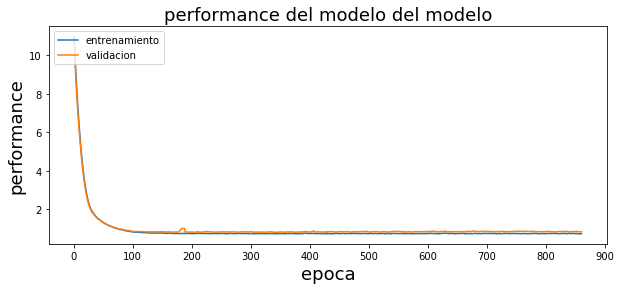

Epoca:  861
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7359 - acc: 0.6662 - val_loss: 0.8532 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  862
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7357 - acc: 0.6657 - val_loss: 0.8364 - val_acc: 0.5784

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  863
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7276 - acc: 0.6801 - val_loss: 0.8334 - val_acc: 0.5835

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  864
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - 

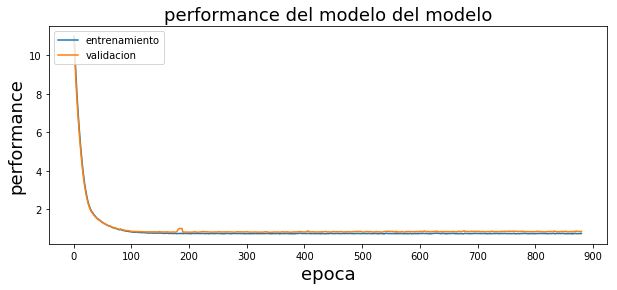

Epoca:  881
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7475 - acc: 0.6603 - val_loss: 0.8472 - val_acc: 0.5835

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  882
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7381 - acc: 0.6690 - val_loss: 0.8445 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  883
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7393 - acc: 0.6613 - val_loss: 0.8498 - val_acc: 0.5824

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  884
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - 

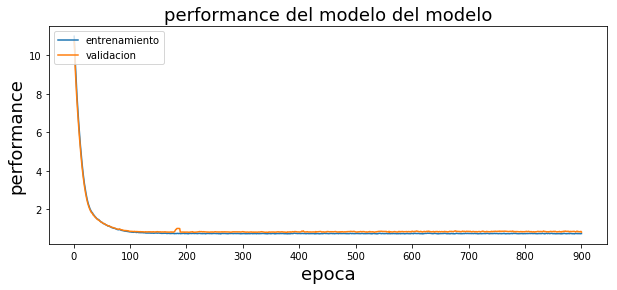

Epoca:  901
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 51us/step - loss: 0.7348 - acc: 0.6669 - val_loss: 0.8275 - val_acc: 0.5907

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  902
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7368 - acc: 0.6633 - val_loss: 0.8320 - val_acc: 0.5902

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  903
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7387 - acc: 0.6652 - val_loss: 0.8426 - val_acc: 0.5935

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  904
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - 

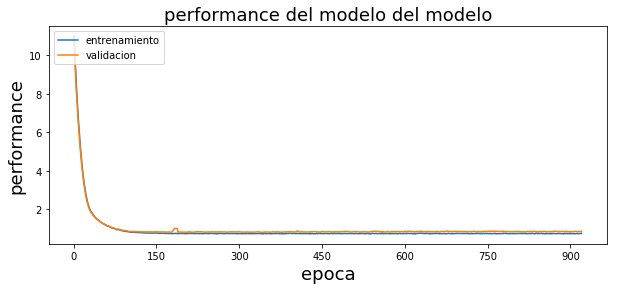

Epoca:  921
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7446 - acc: 0.6704 - val_loss: 0.8582 - val_acc: 0.5790

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  922
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7423 - acc: 0.6683 - val_loss: 0.8542 - val_acc: 0.5879

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  923
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7406 - acc: 0.6690 - val_loss: 0.8638 - val_acc: 0.5768

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  924
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

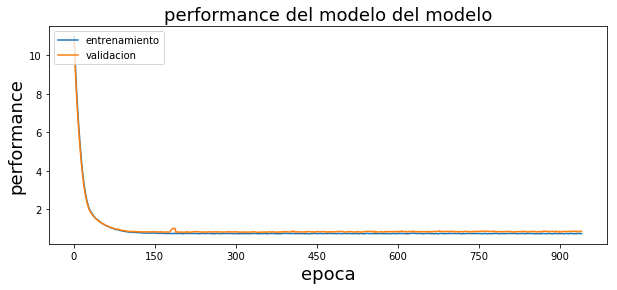

Epoca:  941
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7302 - acc: 0.6780 - val_loss: 0.8509 - val_acc: 0.5868

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  942
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7361 - acc: 0.6763 - val_loss: 0.8455 - val_acc: 0.5935

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  943
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7426 - acc: 0.6622 - val_loss: 0.8297 - val_acc: 0.5790

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  944
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

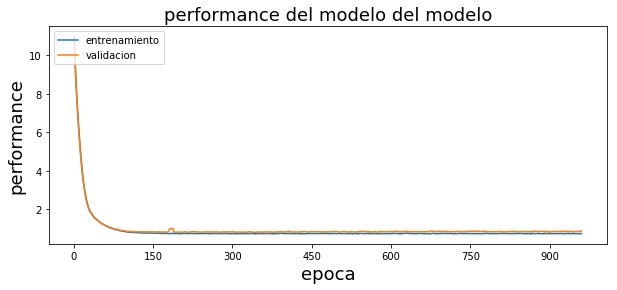

Epoca:  961
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7472 - acc: 0.6587 - val_loss: 0.8687 - val_acc: 0.6153

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  962
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7328 - acc: 0.6702 - val_loss: 0.8773 - val_acc: 0.6075

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  963
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7401 - acc: 0.6731 - val_loss: 0.8487 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  964
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

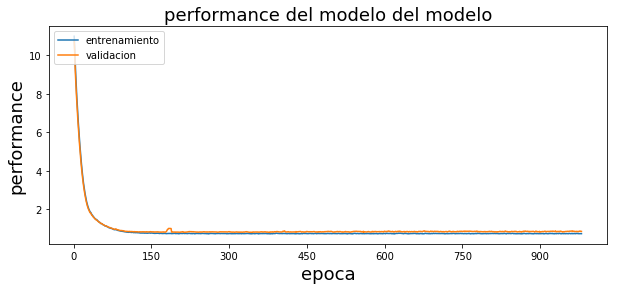

Epoca:  981
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7352 - acc: 0.6693 - val_loss: 0.8442 - val_acc: 0.5812

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  982
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7398 - acc: 0.6650 - val_loss: 0.8547 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  983
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7366 - acc: 0.6669 - val_loss: 0.8632 - val_acc: 0.5779

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  984
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - 

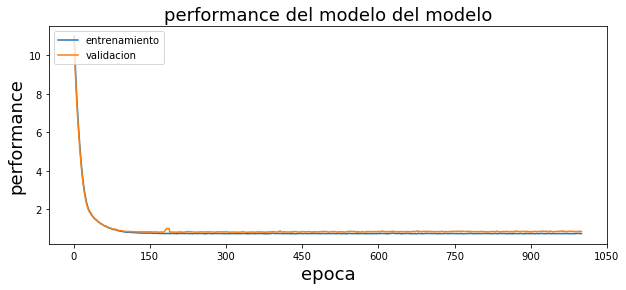

Epoca:  1001
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7308 - acc: 0.6766 - val_loss: 0.8629 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1002
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7365 - acc: 0.6742 - val_loss: 0.8634 - val_acc: 0.6008

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1003
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7426 - acc: 0.6608 - val_loss: 0.8691 - val_acc: 0.5840

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1004
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

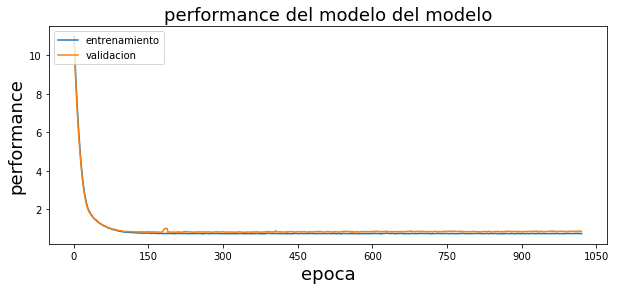

Epoca:  1021
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7381 - acc: 0.6686 - val_loss: 0.8378 - val_acc: 0.5974

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1022
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7403 - acc: 0.6731 - val_loss: 0.8484 - val_acc: 0.5997

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1023
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 50us/step - loss: 0.7424 - acc: 0.6693 - val_loss: 0.8540 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1024
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

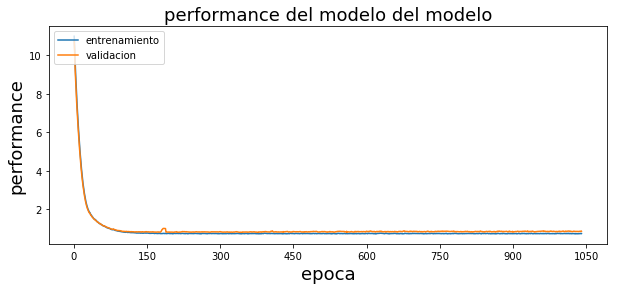

Epoca:  1041
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7380 - acc: 0.6799 - val_loss: 0.8610 - val_acc: 0.5885

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1042
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7627 - acc: 0.6520 - val_loss: 0.8653 - val_acc: 0.5807

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1043
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7573 - acc: 0.6572 - val_loss: 0.8553 - val_acc: 0.5857

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1044
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

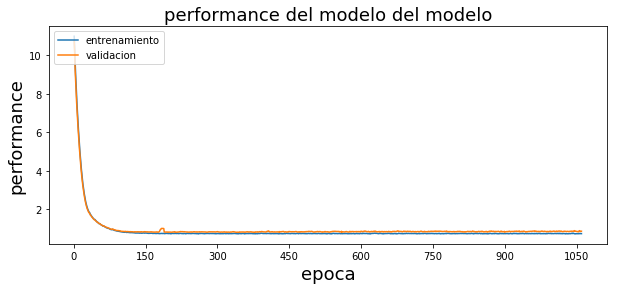

Epoca:  1061
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 48us/step - loss: 0.7319 - acc: 0.6761 - val_loss: 0.8569 - val_acc: 0.6086

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1062
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7563 - acc: 0.6612 - val_loss: 0.8620 - val_acc: 0.5812

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1063
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7432 - acc: 0.6705 - val_loss: 0.8663 - val_acc: 0.5980

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1064
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/ste

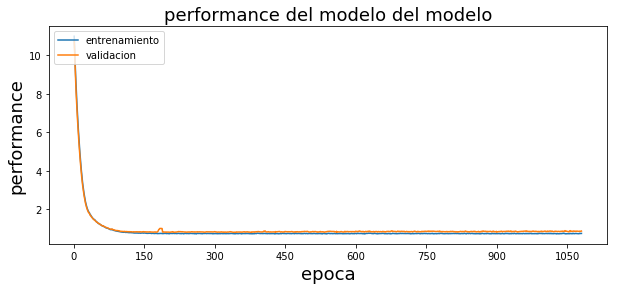

Epoca:  1081
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7475 - acc: 0.6659 - val_loss: 0.8495 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1082
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7476 - acc: 0.6711 - val_loss: 0.8395 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1083
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7386 - acc: 0.6716 - val_loss: 0.8451 - val_acc: 0.5941

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1084
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

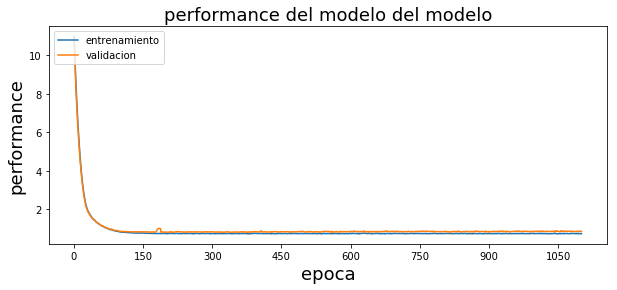

Epoca:  1101
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7381 - acc: 0.6676 - val_loss: 0.8625 - val_acc: 0.6103

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1102
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7366 - acc: 0.6695 - val_loss: 0.8648 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1103
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7425 - acc: 0.6634 - val_loss: 0.8583 - val_acc: 0.6030

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1104
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

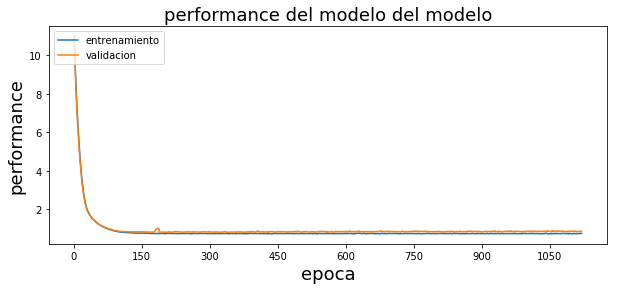

Epoca:  1121
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7326 - acc: 0.6745 - val_loss: 0.8647 - val_acc: 0.6164

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1122
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 48us/step - loss: 0.7402 - acc: 0.6579 - val_loss: 0.8721 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1123
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7341 - acc: 0.6759 - val_loss: 0.8772 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1124
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

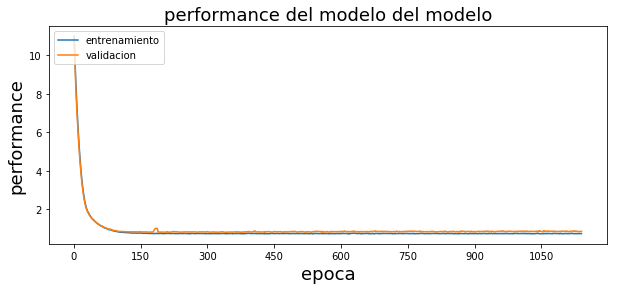

Epoca:  1141
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7323 - acc: 0.6709 - val_loss: 0.8601 - val_acc: 0.5930

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1142
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7409 - acc: 0.6698 - val_loss: 0.8700 - val_acc: 0.5846

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1143
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7388 - acc: 0.6764 - val_loss: 0.8485 - val_acc: 0.5667

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1144
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

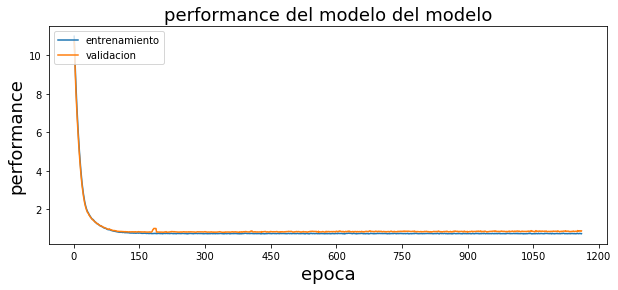

Epoca:  1161
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7441 - acc: 0.6634 - val_loss: 0.8803 - val_acc: 0.5667

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1162
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7512 - acc: 0.6593 - val_loss: 0.8835 - val_acc: 0.6036

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1163
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7578 - acc: 0.6587 - val_loss: 0.8692 - val_acc: 0.5885

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1164
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/ste

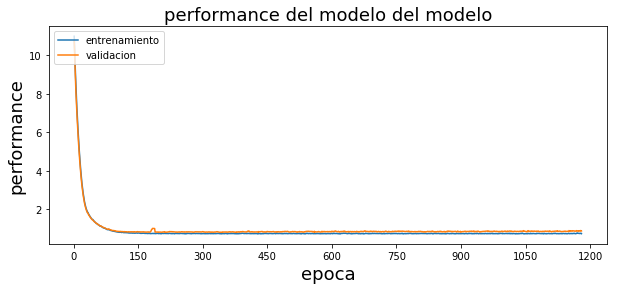

Epoca:  1181
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7509 - acc: 0.6711 - val_loss: 0.8729 - val_acc: 0.6103

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1182
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7438 - acc: 0.6815 - val_loss: 0.8625 - val_acc: 0.6147

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1183
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7415 - acc: 0.6730 - val_loss: 0.8777 - val_acc: 0.5857

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1184
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

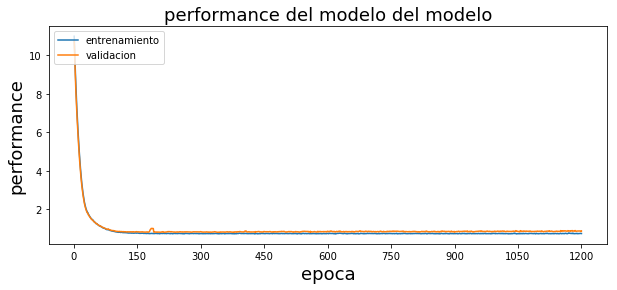

Epoca:  1201
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7401 - acc: 0.6757 - val_loss: 0.8752 - val_acc: 0.6119

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1202
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7301 - acc: 0.6787 - val_loss: 0.8713 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1203
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7300 - acc: 0.6759 - val_loss: 0.8737 - val_acc: 0.6181

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1204
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

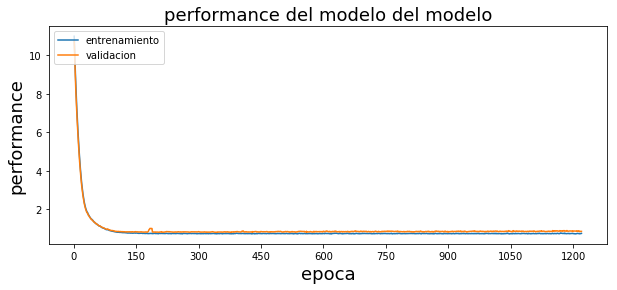

Epoca:  1221
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7345 - acc: 0.6773 - val_loss: 0.8661 - val_acc: 0.6030

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1222
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7388 - acc: 0.6735 - val_loss: 0.8588 - val_acc: 0.5857

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1223
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7469 - acc: 0.6594 - val_loss: 0.8509 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1224
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

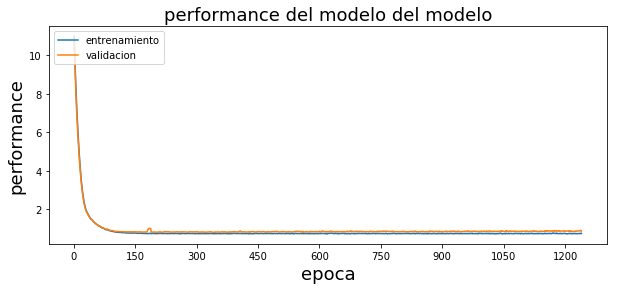

Epoca:  1241
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7438 - acc: 0.6754 - val_loss: 0.8820 - val_acc: 0.5879

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1242
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7527 - acc: 0.6631 - val_loss: 0.8807 - val_acc: 0.5952

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1243
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7496 - acc: 0.6704 - val_loss: 0.8828 - val_acc: 0.5796

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1244
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/ste

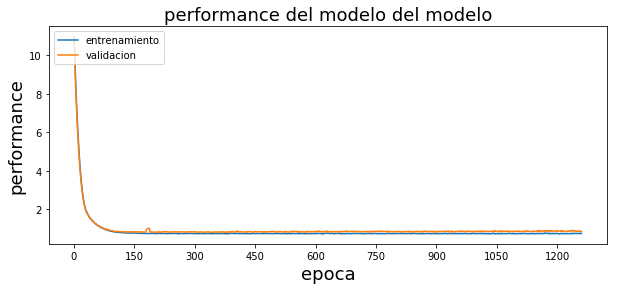

Epoca:  1261
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7468 - acc: 0.6770 - val_loss: 0.8414 - val_acc: 0.5958

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1262
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7518 - acc: 0.6598 - val_loss: 0.8418 - val_acc: 0.5885

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1263
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7419 - acc: 0.6740 - val_loss: 0.8601 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1264
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

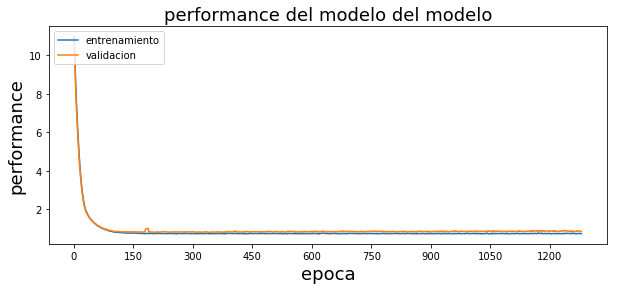

Epoca:  1281
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 48us/step - loss: 0.7325 - acc: 0.6809 - val_loss: 0.8579 - val_acc: 0.5980

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1282
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7367 - acc: 0.6733 - val_loss: 0.8525 - val_acc: 0.5628

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1283
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 52us/step - loss: 0.7315 - acc: 0.6737 - val_loss: 0.8535 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1284
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 49us/ste

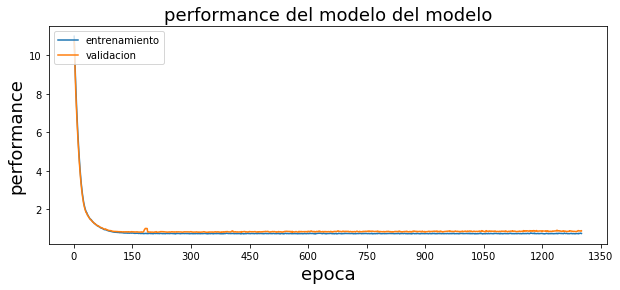

Epoca:  1301
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7450 - acc: 0.6735 - val_loss: 0.8627 - val_acc: 0.5980

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1302
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7427 - acc: 0.6759 - val_loss: 0.8716 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1303
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7555 - acc: 0.6586 - val_loss: 0.8509 - val_acc: 0.6058

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1304
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

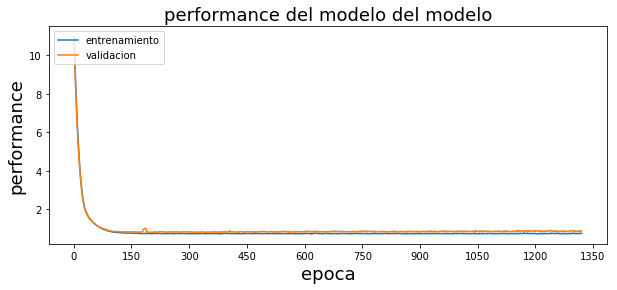

Epoca:  1321
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7510 - acc: 0.6728 - val_loss: 0.8618 - val_acc: 0.5690

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1322
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7507 - acc: 0.6686 - val_loss: 0.8696 - val_acc: 0.5729

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1323
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7471 - acc: 0.6679 - val_loss: 0.8689 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1324
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

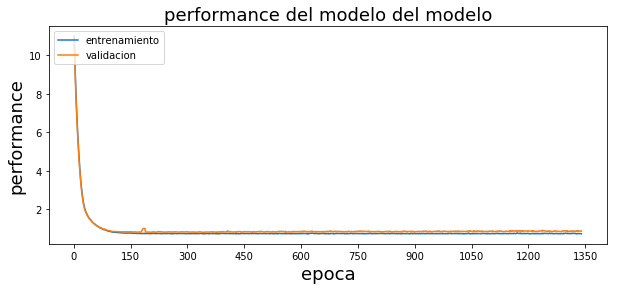

Epoca:  1341
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7313 - acc: 0.6841 - val_loss: 0.8572 - val_acc: 0.5930

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1342
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7388 - acc: 0.6724 - val_loss: 0.8588 - val_acc: 0.5779

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1343
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7369 - acc: 0.6718 - val_loss: 0.8701 - val_acc: 0.6013

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1344
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

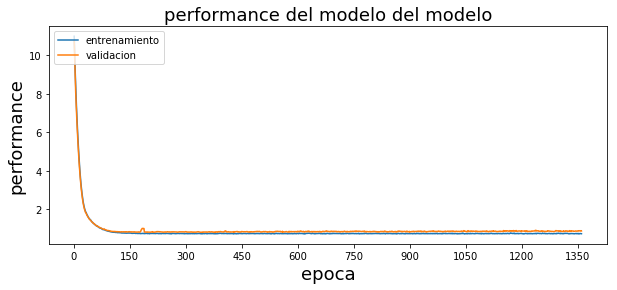

Epoca:  1361
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7325 - acc: 0.6752 - val_loss: 0.8709 - val_acc: 0.5952

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1362
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7366 - acc: 0.6726 - val_loss: 0.8599 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1363
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7482 - acc: 0.6612 - val_loss: 0.8838 - val_acc: 0.6052

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1364
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

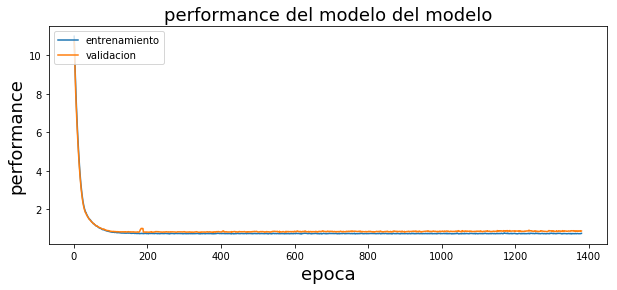

Epoca:  1381
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7535 - acc: 0.6662 - val_loss: 0.8696 - val_acc: 0.5958

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1382
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7433 - acc: 0.6721 - val_loss: 0.8551 - val_acc: 0.5952

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1383
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7378 - acc: 0.6780 - val_loss: 0.8605 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1384
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/ste

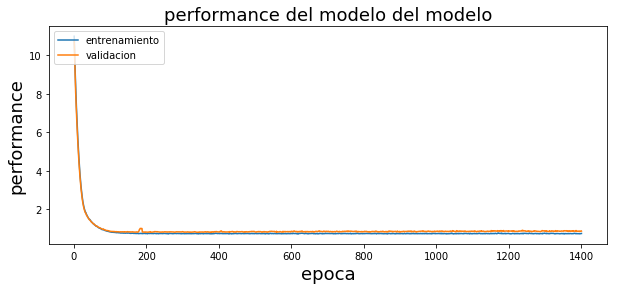

Epoca:  1401
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7285 - acc: 0.6752 - val_loss: 0.8783 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1402
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7407 - acc: 0.6716 - val_loss: 0.8570 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1403
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 38us/step - loss: 0.7427 - acc: 0.6667 - val_loss: 0.8617 - val_acc: 0.5991

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1404
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/ste

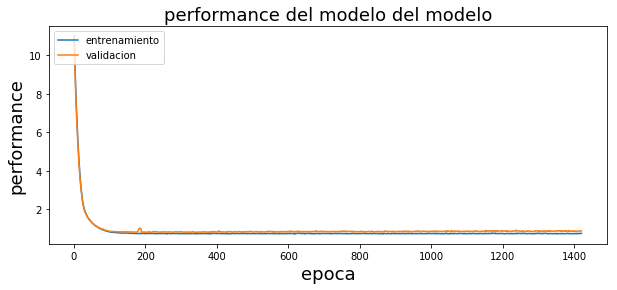

Epoca:  1421
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7453 - acc: 0.6693 - val_loss: 0.8821 - val_acc: 0.5918

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1422
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7371 - acc: 0.6823 - val_loss: 0.8818 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1423
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7440 - acc: 0.6716 - val_loss: 0.8624 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1424
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

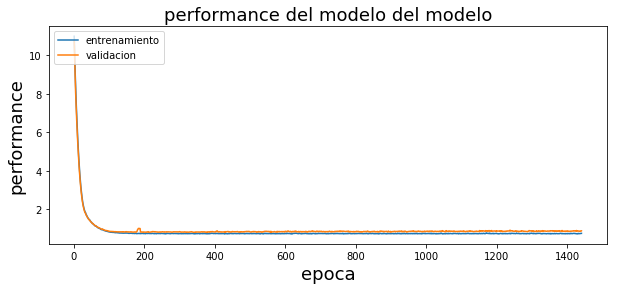

Epoca:  1441
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7493 - acc: 0.6686 - val_loss: 0.8632 - val_acc: 0.6119

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1442
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7369 - acc: 0.6782 - val_loss: 0.8733 - val_acc: 0.6041

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1443
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7480 - acc: 0.6598 - val_loss: 0.8814 - val_acc: 0.5980

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1444
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

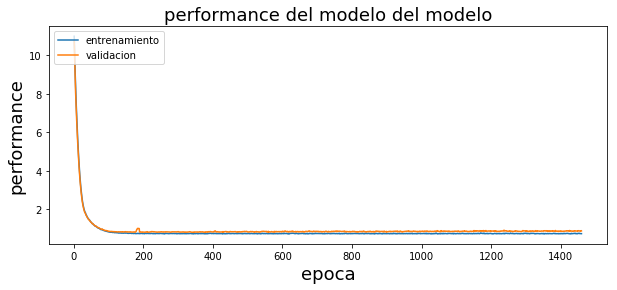

Epoca:  1461
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7321 - acc: 0.6763 - val_loss: 0.8652 - val_acc: 0.6125

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1462
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 49us/step - loss: 0.7316 - acc: 0.6782 - val_loss: 0.8677 - val_acc: 0.5824

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1463
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 48us/step - loss: 0.7256 - acc: 0.6835 - val_loss: 0.8836 - val_acc: 0.5729

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1464
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 49us/ste

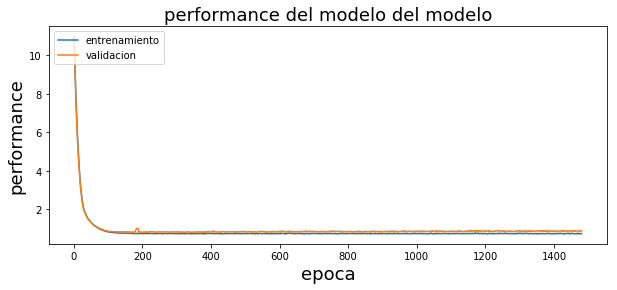

Epoca:  1481
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7338 - acc: 0.6835 - val_loss: 0.8890 - val_acc: 0.5974

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1482
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7356 - acc: 0.6802 - val_loss: 0.8934 - val_acc: 0.6025

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1483
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7372 - acc: 0.6674 - val_loss: 0.8873 - val_acc: 0.5868

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1484
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 49us/ste

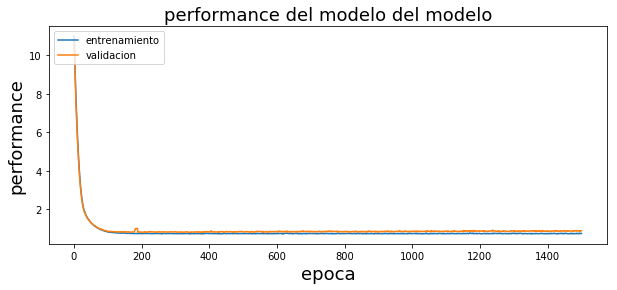

Epoca:  1501
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7517 - acc: 0.6716 - val_loss: 0.8825 - val_acc: 0.5796

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1502
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7424 - acc: 0.6652 - val_loss: 0.8777 - val_acc: 0.5662

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1503
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7417 - acc: 0.6641 - val_loss: 0.8755 - val_acc: 0.5673

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1504
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

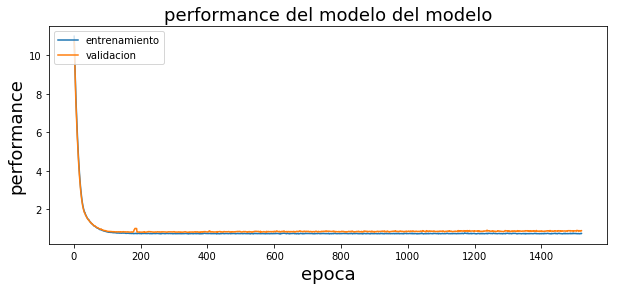

Epoca:  1521
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7476 - acc: 0.6688 - val_loss: 0.8649 - val_acc: 0.5885

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1522
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7388 - acc: 0.6778 - val_loss: 0.8546 - val_acc: 0.5985

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1523
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7446 - acc: 0.6726 - val_loss: 0.8650 - val_acc: 0.5835

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1524
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

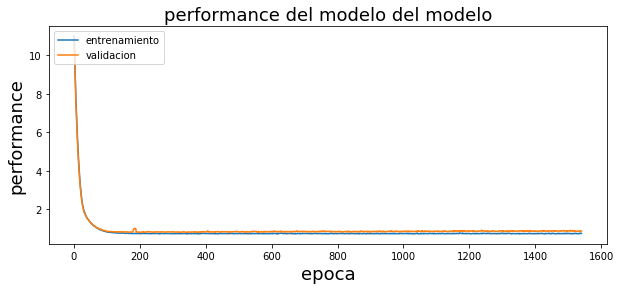

Epoca:  1541
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - ETA: 0s - loss: 0.7434 - acc: 0.690 - 0s 41us/step - loss: 0.7434 - acc: 0.6903 - val_loss: 0.8792 - val_acc: 0.5918

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1542
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7521 - acc: 0.6690 - val_loss: 0.8648 - val_acc: 0.5812

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1543
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7398 - acc: 0.6712 - val_loss: 0.8633 - val_acc: 0.5918

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1544
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [=======

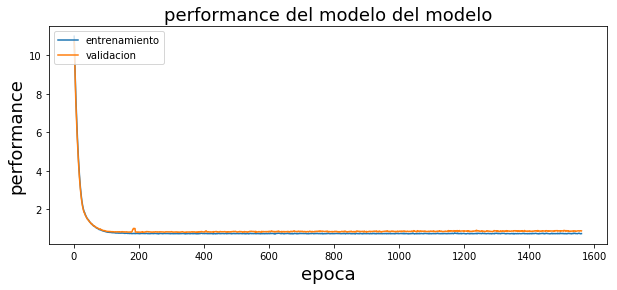

Epoca:  1561
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7380 - acc: 0.6733 - val_loss: 0.8704 - val_acc: 0.5969

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1562
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7365 - acc: 0.6730 - val_loss: 0.8624 - val_acc: 0.6008

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1563
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7337 - acc: 0.6776 - val_loss: 0.8592 - val_acc: 0.5952

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1564
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

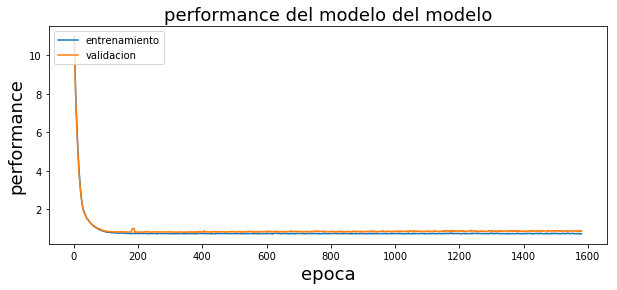

Epoca:  1581
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7295 - acc: 0.6900 - val_loss: 0.8698 - val_acc: 0.6181

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1582
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7506 - acc: 0.6664 - val_loss: 0.8641 - val_acc: 0.6092

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1583
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7480 - acc: 0.6709 - val_loss: 0.8678 - val_acc: 0.6013

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1584
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

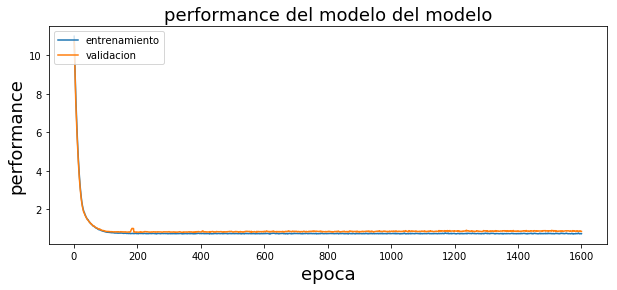

Epoca:  1601
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7317 - acc: 0.6815 - val_loss: 0.8635 - val_acc: 0.5723

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1602
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7473 - acc: 0.6643 - val_loss: 0.8539 - val_acc: 0.5784

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1603
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7329 - acc: 0.6818 - val_loss: 0.8652 - val_acc: 0.5734

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1604
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

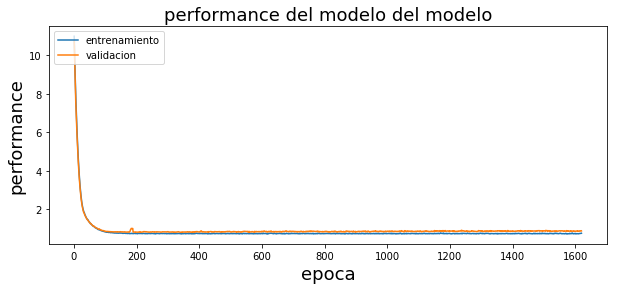

Epoca:  1621
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7419 - acc: 0.6780 - val_loss: 0.8704 - val_acc: 0.5717

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1622
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7305 - acc: 0.6844 - val_loss: 0.8714 - val_acc: 0.6047

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1623
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7344 - acc: 0.6789 - val_loss: 0.8765 - val_acc: 0.5941

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1624
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

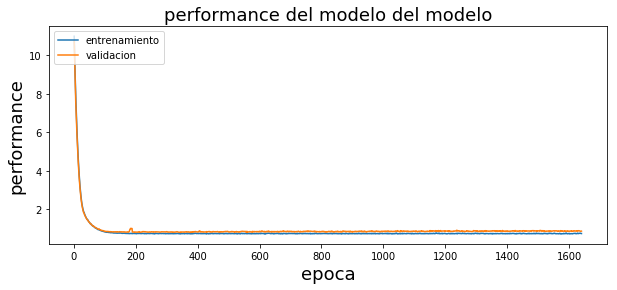

Epoca:  1641
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7388 - acc: 0.6719 - val_loss: 0.8705 - val_acc: 0.5958

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1642
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7381 - acc: 0.6770 - val_loss: 0.8601 - val_acc: 0.5874

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1643
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7390 - acc: 0.6763 - val_loss: 0.8652 - val_acc: 0.6036

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1644
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/ste

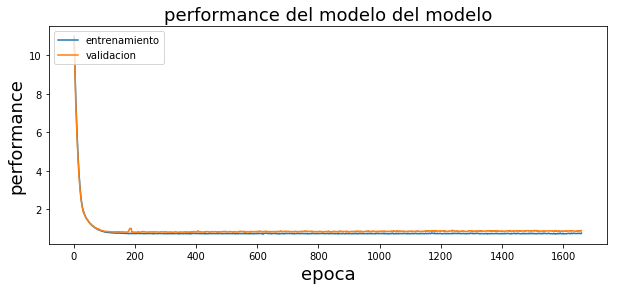

Epoca:  1661
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7438 - acc: 0.6789 - val_loss: 0.8881 - val_acc: 0.5662

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1662
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7507 - acc: 0.6688 - val_loss: 0.8611 - val_acc: 0.6069

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1663
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7435 - acc: 0.6737 - val_loss: 0.8615 - val_acc: 0.6125

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1664
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

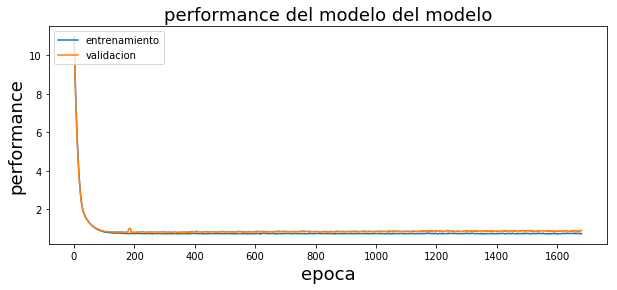

Epoca:  1681
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7447 - acc: 0.6745 - val_loss: 0.8838 - val_acc: 0.6136

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1682
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7488 - acc: 0.6763 - val_loss: 0.8588 - val_acc: 0.5963

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1683
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7411 - acc: 0.6802 - val_loss: 0.8810 - val_acc: 0.5868

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1684
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/ste

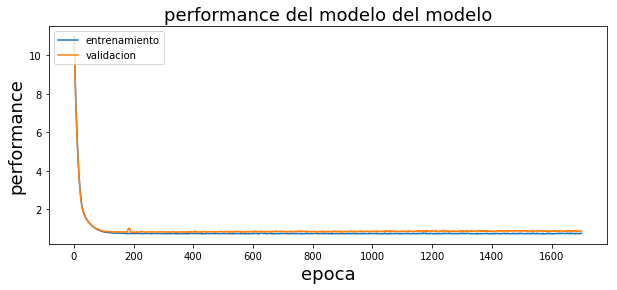

Epoca:  1701
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7553 - acc: 0.6749 - val_loss: 0.8801 - val_acc: 0.6075

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1702
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7453 - acc: 0.6804 - val_loss: 0.8920 - val_acc: 0.6108

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1703
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7395 - acc: 0.6693 - val_loss: 0.8881 - val_acc: 0.6097

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1704
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/ste

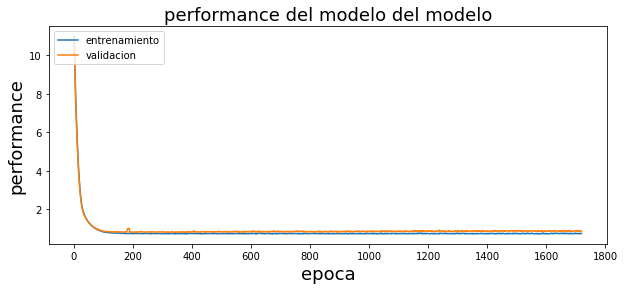

Epoca:  1721
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7419 - acc: 0.6738 - val_loss: 0.8789 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1722
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7459 - acc: 0.6815 - val_loss: 0.8855 - val_acc: 0.5645

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1723
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7444 - acc: 0.6752 - val_loss: 0.8671 - val_acc: 0.5930

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1724
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

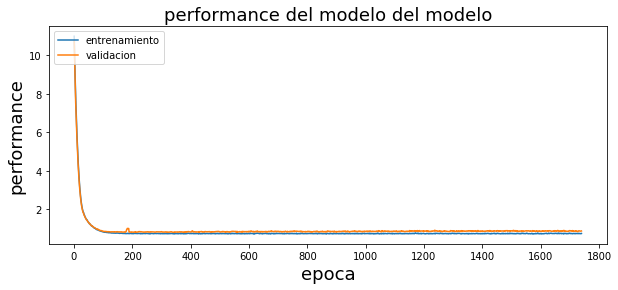

Epoca:  1741
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7345 - acc: 0.6839 - val_loss: 0.8793 - val_acc: 0.5974

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1742
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7503 - acc: 0.6740 - val_loss: 0.8939 - val_acc: 0.6069

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1743
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7614 - acc: 0.6664 - val_loss: 0.8964 - val_acc: 0.5907

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1744
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/ste

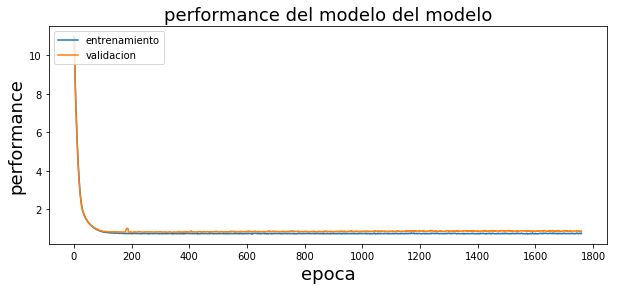

Epoca:  1761
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7478 - acc: 0.6686 - val_loss: 0.8659 - val_acc: 0.6058

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1762
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7355 - acc: 0.6896 - val_loss: 0.8934 - val_acc: 0.5958

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1763
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7539 - acc: 0.6636 - val_loss: 0.9054 - val_acc: 0.5896

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1764
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

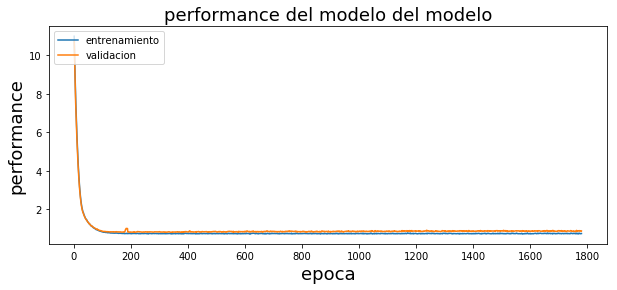

Epoca:  1781
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7305 - acc: 0.6856 - val_loss: 0.8686 - val_acc: 0.5935

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1782
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7559 - acc: 0.6711 - val_loss: 0.8714 - val_acc: 0.5851

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1783
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7527 - acc: 0.6761 - val_loss: 0.8625 - val_acc: 0.6030

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1784
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/ste

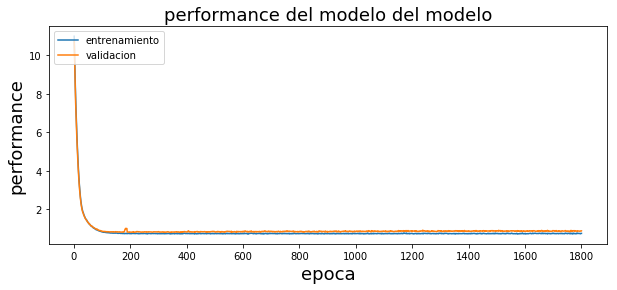

Epoca:  1801
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7477 - acc: 0.6733 - val_loss: 0.8870 - val_acc: 0.5863

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1802
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7502 - acc: 0.6646 - val_loss: 0.8917 - val_acc: 0.5807

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1803
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7375 - acc: 0.6783 - val_loss: 0.8921 - val_acc: 0.5902

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1804
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/ste

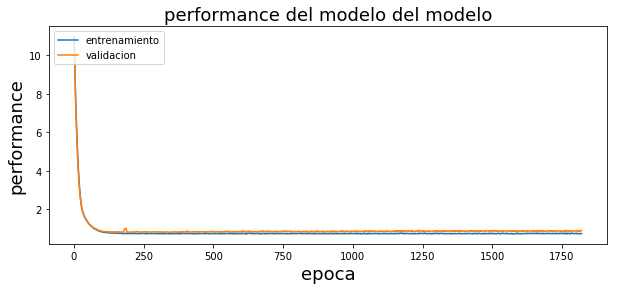

Epoca:  1821
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7342 - acc: 0.6770 - val_loss: 0.9112 - val_acc: 0.5835

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1822
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7434 - acc: 0.6775 - val_loss: 0.8980 - val_acc: 0.5840

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1823
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7479 - acc: 0.6780 - val_loss: 0.9083 - val_acc: 0.5868

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1824
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/ste

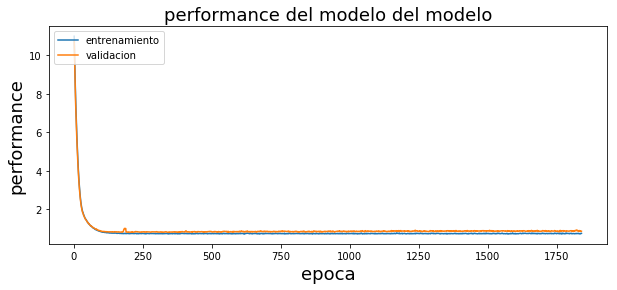

Epoca:  1841
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7413 - acc: 0.6773 - val_loss: 0.8774 - val_acc: 0.6058

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1842
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7427 - acc: 0.6714 - val_loss: 0.8657 - val_acc: 0.6203

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1843
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7469 - acc: 0.6782 - val_loss: 0.8782 - val_acc: 0.6114

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1844
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

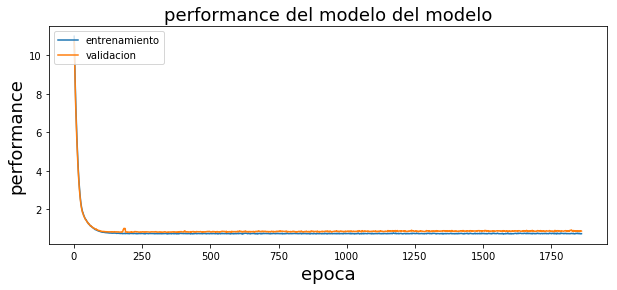

Epoca:  1861
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7460 - acc: 0.6659 - val_loss: 0.8731 - val_acc: 0.6164

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1862
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 45us/step - loss: 0.7404 - acc: 0.6785 - val_loss: 0.8787 - val_acc: 0.5913

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1863
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7367 - acc: 0.6813 - val_loss: 0.8873 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1864
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 49us/ste

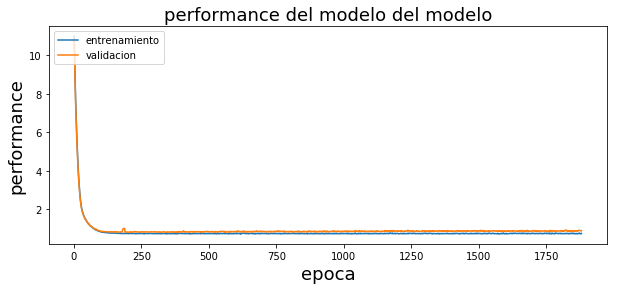

Epoca:  1881
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 46us/step - loss: 0.7509 - acc: 0.6726 - val_loss: 0.8870 - val_acc: 0.6041

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1882
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7536 - acc: 0.6692 - val_loss: 0.8787 - val_acc: 0.5583

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1883
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7478 - acc: 0.6761 - val_loss: 0.8929 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1884
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/ste

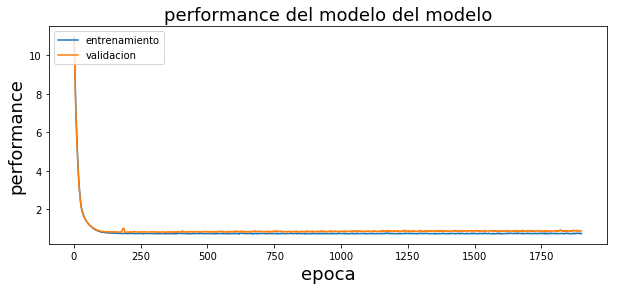

Epoca:  1901
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 44us/step - loss: 0.7383 - acc: 0.6766 - val_loss: 0.8867 - val_acc: 0.5701

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1902
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7423 - acc: 0.6738 - val_loss: 0.8894 - val_acc: 0.5857

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1903
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7442 - acc: 0.6726 - val_loss: 0.8890 - val_acc: 0.6019

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1904
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/ste

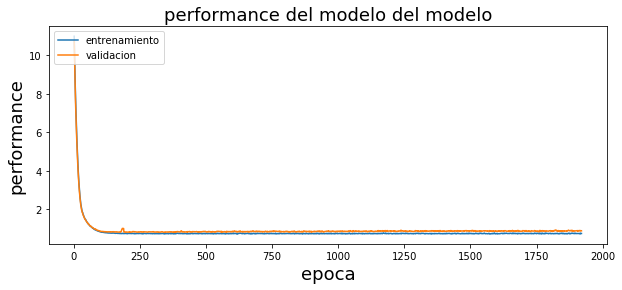

Epoca:  1921
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7380 - acc: 0.6790 - val_loss: 0.8709 - val_acc: 0.5958

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1922
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 43us/step - loss: 0.7347 - acc: 0.6782 - val_loss: 0.8675 - val_acc: 0.6097

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1923
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7447 - acc: 0.6815 - val_loss: 0.8589 - val_acc: 0.5891

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1924
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

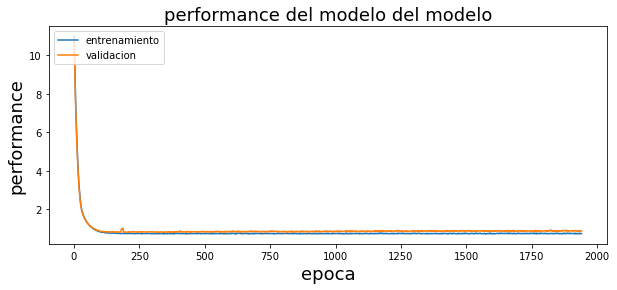

Epoca:  1941
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 61us/step - loss: 0.7379 - acc: 0.6815 - val_loss: 0.8968 - val_acc: 0.5784

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1942
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 47us/step - loss: 0.7406 - acc: 0.6806 - val_loss: 0.8899 - val_acc: 0.5907

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1943
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7436 - acc: 0.6716 - val_loss: 0.9042 - val_acc: 0.5712

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1944
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/ste

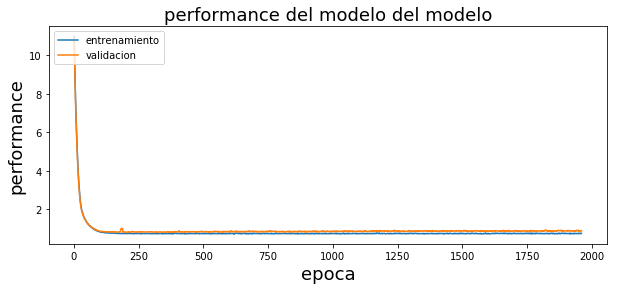

Epoca:  1961
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7490 - acc: 0.6669 - val_loss: 0.8888 - val_acc: 0.5762

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1962
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7465 - acc: 0.6702 - val_loss: 0.8922 - val_acc: 0.5941

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1963
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 42us/step - loss: 0.7607 - acc: 0.6695 - val_loss: 0.8930 - val_acc: 0.5829

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1964
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/ste

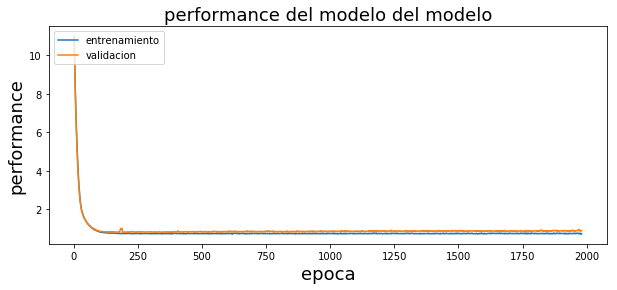

Epoca:  1981
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 39us/step - loss: 0.7262 - acc: 0.6806 - val_loss: 0.8885 - val_acc: 0.6008

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1982
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 41us/step - loss: 0.7348 - acc: 0.6891 - val_loss: 0.8717 - val_acc: 0.5863

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1983
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/step - loss: 0.7350 - acc: 0.6806 - val_loss: 0.8919 - val_acc: 0.5779

Epoch 00001: val_loss did not improve from 0.80084

Epoch 00001: saving model to last_model.h5
Epoca:  1984
Train on 5767 samples, validate on 1791 samples
Epoch 1/1
5767/5767 [==============================] - 0s 40us/ste

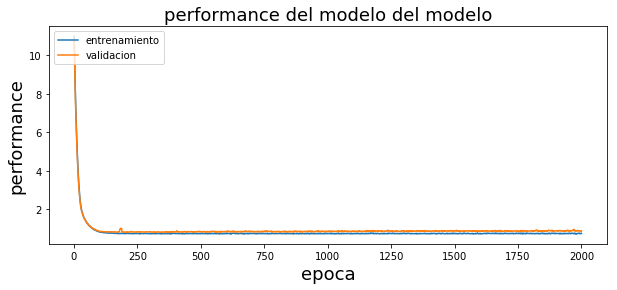

Wall time: 11min 35s


In [49]:
%%time
#LOAD_MODEL = True
LOAD_MODEL = False

monitor = 'loss'
mode = 'min'

if not LOAD_MODEL:
    epochs = 2000
    batch_size = 128
    
    import pickle

    filepath="best_model.h5"
    filepath_2="last_model.h5"
    
    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_'+monitor,
                                 verbose=1,
                                 save_best_only=True,
                                 mode=mode) # graba sólo los que mejoran en validación
    checkpoint_2 = ModelCheckpoint(filepath_2,
                                 monitor='val_'+monitor,
                                 verbose=1,
                                 save_best_only=False,
                                 mode=mode) # graba el último
    
    callbacks_list = [checkpoint, checkpoint_2]
    for e in range(epochs):
        print("Epoca: ", e+1)
        
        
        inds_tr=np.random.permutation(len(X_tr_sc))
        inds_tr_va=np.random.permutation(len(X_va_sc))
        
        
        history = modelo_desacoplado.fit(X_tr_sc[inds_tr], y_tr[inds_tr],
                                         batch_size=batch_size,
                                         epochs=1,
                                         callbacks=callbacks_list,
                                         verbose=1,
                                         validation_data=(X_va_sc[inds_tr_va], y_va[inds_tr_va]),
                                         class_weight=class_weights
                                        )
  #      history = modelo_desacoplado.fit(X_tr_sc, y_tr,
  #                                       batch_size=batch_size,
  #                                       epochs=1,
  #                                       callbacks=callbacks_list,
  #                                       verbose=1,
  #                                       validation_data=(X_va_sc, y_va),
  #                                       class_weight=class_weights
  #                                      )
  #          
        acum_tr = acum_tr + history.history[monitor]
        acum_val = acum_val + history.history['val_'+monitor]
        
        val_acc= val_acc + history.history['val_acc']
        acc = acc +  history.history['acc']
        
        if len(acum_tr) > 1 and ((e+1)%20 == 0):
            grafica_entrenamiento(acum_tr, acum_val)

Elegir  mejor modelo o último modelo:

In [59]:
modelo_desacoplado = load_model('best_model.h5')
#modelo_desacoplado = load_model('last_model.h5')


## Resultados obtenidos

In [60]:
score_tr = modelo_desacoplado.evaluate(X_tr_sc, y_tr, verbose=1)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = modelo_desacoplado.evaluate(X_va_sc, y_va, verbose=1)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = modelo_desacoplado.evaluate(X_test_sc, y_test, verbose=1)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

5767/5767 [==============================] - 0s 61us/step
Train loss    : 0.717084793381371
Train accuracy: 0.6991503381617503
1791/1791 [==============================] - 0s 31us/step
Val loss    : 0.8008427969375048
Val accuracy: 0.5728643212752392
1121/1121 [==============================] - 0s 33us/step
Test loss     : 0.8153751146357363
Test accuracy : 0.46743978590544155


In [61]:
y_pred_proba = modelo_desacoplado.predict(X_test_sc)
y_pred = np.round(y_pred_proba)
print('')
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.92      0.44      0.60      1007
          1       0.12      0.68      0.21       114

avg / total       0.84      0.47      0.56      1121



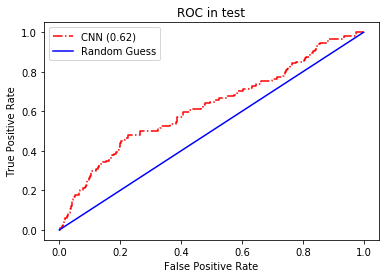

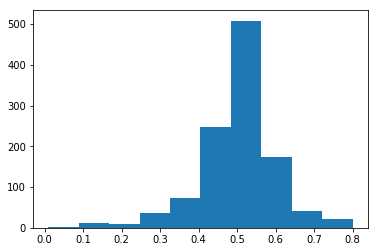

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC in test')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()
plt.hist(y_pred_proba)
plt.show()

### acum_tr ,acum_val

In [63]:
history.history

{'val_loss': [0.8728691818060521],
 'val_acc': [0.6309324398112657],
 'loss': [0.7471006283607933],
 'acc': [0.6830241026736967]}

In [64]:
historia = pd.DataFrame({'val_loss': acum_val,
                         'val_acc': val_acc,
                         'loss': acum_tr,
                         'acc': acc,
                        })


roc = pd.DataFrame({ 'FPRate': fpr,  'TPRate': tpr, 'thresholds':thresholds})


In [65]:
import datetime as dt
historia.to_csv(dt.datetime.now().strftime("%Y%m%d_%H%M_")+"historico_"+"bs_"+str(batch_size)+".csv",
                sep=';', decimal=",",index= False)
roc.to_csv(dt.datetime.now().strftime("%Y%m%d_%H%M_")+"roc_"+"bs_"+str(batch_size)+"_AUC_"+str(np.round(auc(fpr, tpr),2))+".csv",
                sep=';', decimal=",",index= False)


In [66]:
from contextlib import redirect_stdout

with open(dt.datetime.now().strftime("%Y%m%d_%H%M_")+'arquitectura_no_entrenada'+'.txt', 'w') as f:
    with redirect_stdout(f):
        modelo_desacoplado.summary()
        
with open(dt.datetime.now().strftime("%Y%m%d_%H%M_")+'resultados'+'.txt', 'w') as g:
    with redirect_stdout(g):
        print(classification_report(y_test, y_pred))
        
        
# https://stackoverflow.com/questions/45199047/how-to-save-model-summary-to-file-in-keras

In [67]:
plot_model(modelo_desacoplado, to_file=dt.datetime.now().strftime("%Y%m%d_%H%M_")+'arquitectura_no_entrenada'+'.png', 
           show_shapes=False, show_layer_names=True, rankdir='TB')